In [55]:
from collections import defaultdict
from itertools import product
from pathlib import Path

from datasets import load_from_disk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import auc, confusion_matrix, roc_curve, roc_auc_score,  precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from genai_detection.eval_util import compute_metrics

In [12]:
def split_pan_ds_dataset_by_model(df, seed=42):
    df_human = df.query('model.str.strip() == "human"').sample(frac=1, random_state=seed)
    df_machine = {
        'GPT-3': df.query('model.str.startswith("gpt-3")').sample(frac=1, random_state=seed),
        'GPT-4': df.query('model.str.startswith("gpt-4")').sample(frac=1, random_state=seed),
        'o1': df.query('model.str.startswith("openai")').sample(frac=1, random_state=seed),
        'Llama2': df.query('model.str.startswith("llama")').sample(frac=1, random_state=seed),
        'PaLM2': df.query('model.str.startswith("text-bison")').sample(frac=1, random_state=seed),
        'Gemini': df.query('model.str.startswith("gemini")').sample(frac=1, random_state=seed),
        'Mistral': df.query('model.str.startswith("mistral") or model.str.startswith("mixtral")').sample(frac=1, random_state=seed),
        'Qwen': df.query('model.str.startswith("qwen")').sample(frac=1, random_state=seed),
    }
    return df_human, df_machine

In [13]:
ds_pan = load_from_disk('../data/datasets/pan24-extended-converted')
ds_pan = pd.concat([ds_pan['train'].to_pandas().set_index('id'), ds_pan['validation'].to_pandas().set_index('id')])
df_pan_h, df_pan_m = split_pan_ds_dataset_by_model(ds_pan)
assert df_pan_h['label'].count() > 0 and df_pan_h['label'].sum() == 0

ds_pan_test = load_from_disk('../data/datasets/pan24-extended-converted')['test'].to_pandas().set_index('id')
df_pan_test_h, df_pan_test_m = split_pan_ds_dataset_by_model(ds_pan_test)
assert df_pan_test_h['label'].count() > 0 and df_pan_test_h['label'].sum() == 0

ds_raid_test = load_from_disk('../data/datasets/raid-good-models-converted')['test'].to_pandas().set_index('id')
ds_raid_test_h, ds_raid_test_m = split_pan_ds_dataset_by_model(ds_raid_test)
assert ds_raid_test_h['label'].count() > 0 and ds_raid_test_h['label'].sum() == 0

In [14]:
# TODO!!!
# def calc_metric_matrix(df_train, df_test, pred_fn):
#     metrics = []
#     for tr, te in product(df_train , df_test):
#         m = {'train': tr, 'test': te}
#         preds = pred_fn(te, df_test[te]['text'])
#         m.update(compute_metrics(preds, df_test[te]['label']))
#         m.update({'preds': preds, 'labels': df_test[te]['label']})
#         metrics.append(m)
#
#     return pd.DataFrame(metrics).set_index(['train', 'test'])

### Training and evaluation of classifiers on PAN'24

In [15]:
train = {}
val_pan = {}
test_pan = {}
vec_pan = {}
clf_pan = {}
for model in df_pan_m:
    # Build balanced dataset
    n_train  = min(len(df_pan_m[model]), len(df_pan_h))
    n_val = int(n_train * .2)
    n_train = n_train - n_val

    # Train + validation
    train[model] = pd.concat([df_pan_m[model].iloc[:n_train], df_pan_h.iloc[:n_train]])
    val_pan[model] = pd.concat([df_pan_m[model].iloc[n_train:n_train + n_val], df_pan_h.iloc[n_train:n_train + n_val]])

    # Test
    n_test = min(len(df_pan_test_m[model]), len(df_pan_test_h))
    test_pan[model] = pd.concat([df_pan_test_m[model].iloc[:n_test], df_pan_test_h.iloc[:n_test]])

    vec_pan[model] = TfidfVectorizer(max_features=800, ngram_range=(1, 1), smooth_idf=True)
    # clf_pan[model] = LogisticRegression()
    clf_pan[model] = LinearSVC()
    clf_pan[model].predict_proba = clf_pan[model]._predict_proba_lr
    clf_pan[model].fit(vec_pan[model].fit_transform(train[model]['text']), train[model]['label'])

metrics_pan = []
for m1, m2 in product(df_pan_m, repeat=2):
    # Validation set
    # m_val = {'train': m1, 'test': m2}
    # preds_val = clf_pan[m1]._predict_proba_lr(vec_pan[m1].transform(val_pan[m2]['text']))
    # m_val.update(compute_metrics(preds_val, val_pan[m2]['label']))
    # metrics_pan.append(m_val)

    # Test set (use only once!)
    m_test = {'train': m1, 'test': m2}
    # preds_test = clf_pan[m1]._predict_proba_lr(vec_pan[m1].transform(test_pan[m2]['text']))
    preds_test = clf_pan[m1].predict_proba(vec_pan[m1].transform(test_pan[m2]['text']))
    m_test.update(compute_metrics(preds_test, test_pan[m2]['label']))
    metrics_pan.append(m_test)

metrics_pan = pd.DataFrame(metrics_pan).set_index(['train', 'test'])
metrics_pan

acc   auc_roc               confusion       fpr       fnr  \
train test                                                                      
GPT-3 GPT-3    0.996324  0.999770    [[271, 1], [1, 271]]  0.003676  0.003676   
      GPT-4    0.976103  0.998243   [[271, 1], [12, 260]]  0.003676  0.044118   
      o1       0.740809  0.933432  [[271, 1], [140, 132]]  0.003676  0.514706   
      Llama2   0.818015  0.955098   [[271, 1], [98, 174]]  0.003676  0.360294   
      PaLM2    0.902985  0.980021   [[267, 1], [51, 217]]  0.003731  0.190299   
...                 ...       ...                     ...       ...       ...   
Qwen  Llama2   0.902574  0.976535   [[267, 5], [48, 224]]  0.018382  0.176471   
      PaLM2    0.940299  0.988876   [[263, 5], [27, 241]]  0.018657  0.100746   
      Gemini   0.871324  0.969101   [[267, 5], [65, 207]]  0.018382  0.238971   
      Mistral  0.931985  0.988687   [[267, 5], [32, 240]]  0.018382  0.117647   
      Qwen     0.987132  0.998892    [[267, 5], [2, 270]]  0.018382  0.007353   

               human_prec  human_rec  human_f1  machine_prec  machine_rec  \
train test                                                                  
GPT-3 GPT-3      0.996324   0.996324  0.996324      0.996324     0.996324   
      GPT-4      0.957597   0.996324  0.976577      0.996169     0.955882   
      o1         0.659367   0.996324  0.793558      0.992481     0.485294   
      Llama2     0.734417   0.996324  0.845554      0.994286     0.639706   
      PaLM2      0.839623   0.996269  0.911263      0.995413     0.809701   
...                   ...        ...       ...           ...          ...   
Qwen  Llama2     0.847619   0.981618  0.909710      0.978166     0.823529   
      PaLM2      0.906897   0.981343  0.942652      0.979675     0.899254   
      Gemini     0.804217   0.981618  0.884106      0.976415     0.761029   
      Mistral    0.892977   0.981618  0.935201      0.979592     0.882353   
      Qwen       0.992565   0.981618  0.987061      0.981818     0.992647   

               machine_f1  
train test                 
GPT-3 GPT-3      0.996324  
      GPT-4      0.975610  
      o1         0.651852  
      Llama2     0.778523  
      PaLM2      0.893004  
...                   ...  
Qwen  Llama2     0.894212  
      PaLM2      0.937743  
      Gemini     0.855372  
      Mistral    0.928433  
      Qwen       0.987203  

[64 rows x 11 columns]

In [16]:
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Helvetica, sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['grid.linewidth'] = .25

def plot_classification_heatmap(metrics_df, pivot_field, title=None,
                                xlabel='Model family (training)', ylabel='Model family (test)', savefig=None):
    pivot = metrics_df.reset_index().pivot(columns='train', index='test', values=pivot_field)
    plt.figure(figsize=(3.5, 3))

    ax = sns.heatmap(pivot,  annot=True,  vmin=0, vmax=1, cmap=sns.color_palette('crest', as_cmap=True), fmt='.2f')
    ax.set_title(title or pivot_field)

    ax.set_xlabel(xlabel)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    ax.set_ylabel(ylabel)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

    plt.tight_layout(pad=.8)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight', pad_inches=0)
    plt.show()

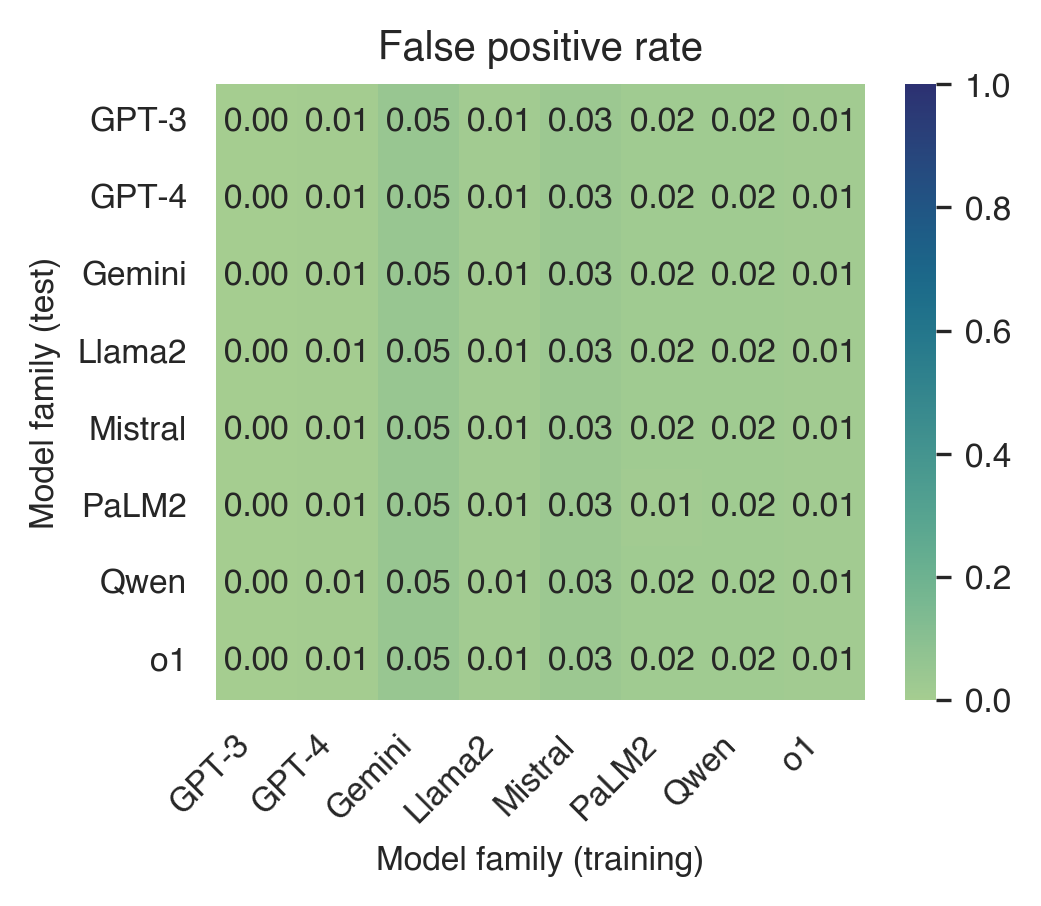

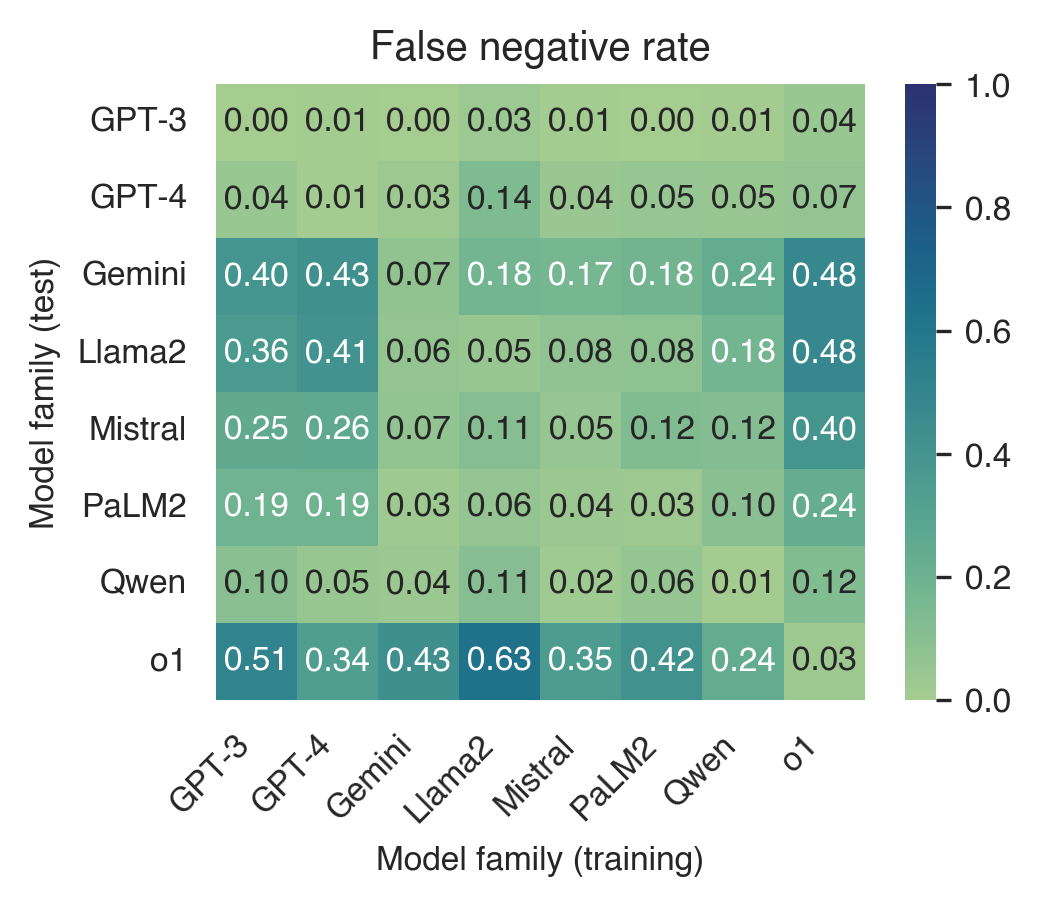

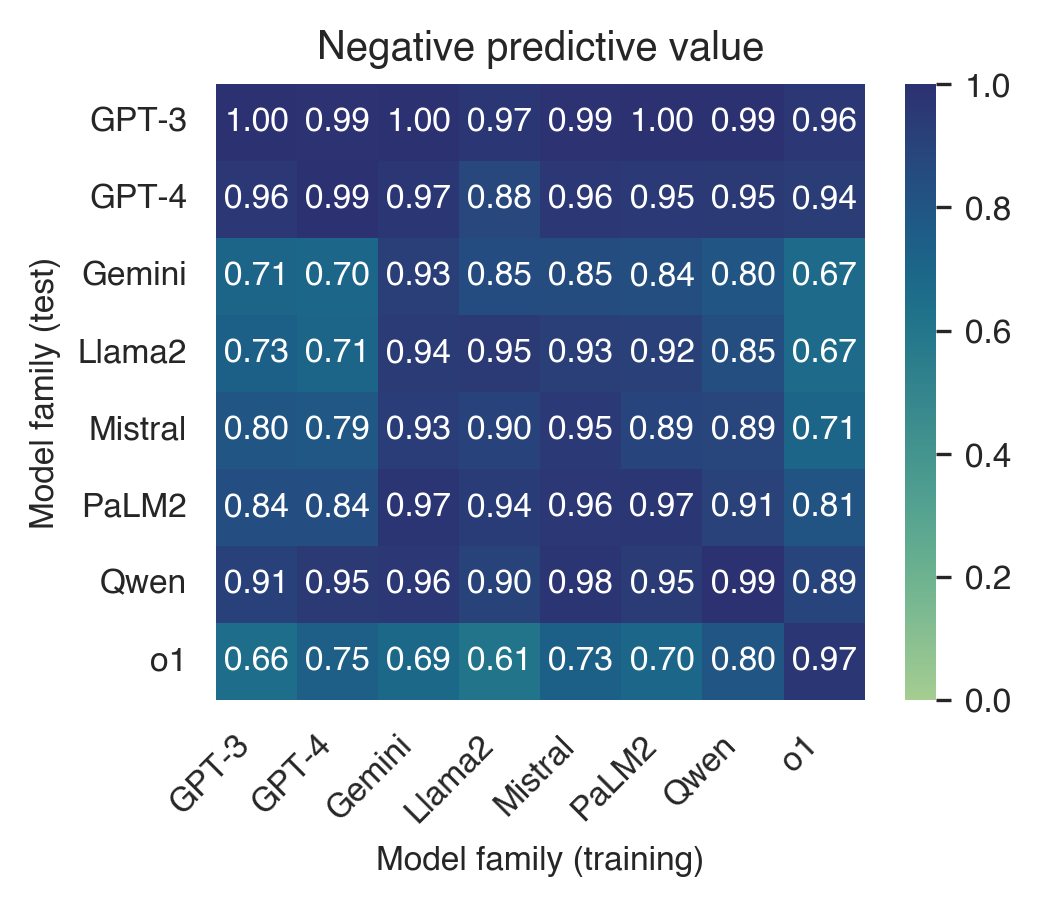

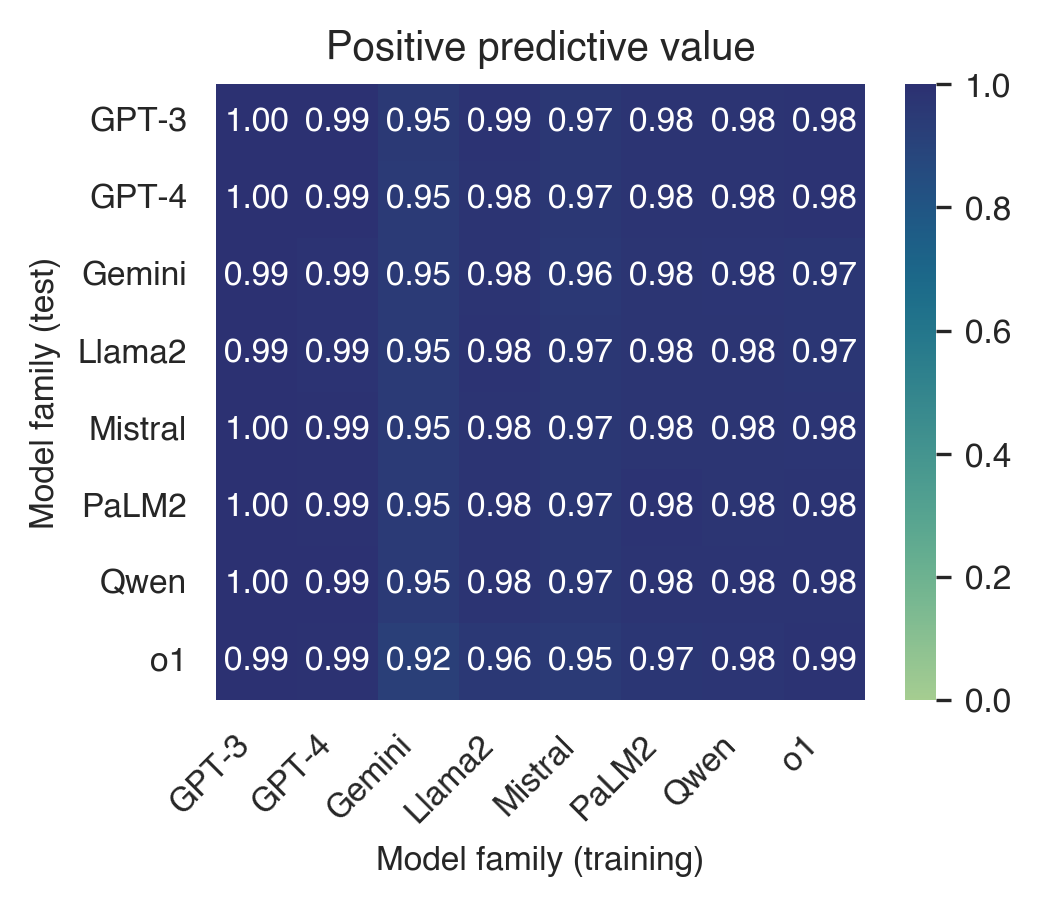

In [17]:
plot_classification_heatmap(metrics_pan, 'fpr', title='False positive rate', savefig='../data/figures/classification-svm-pan-fpr.pdf')
plot_classification_heatmap(metrics_pan, 'fnr', title='False negative rate', savefig='../data/figures/classification-svm-pan-fnr.pdf')
plot_classification_heatmap(metrics_pan, 'human_prec', title='Negative predictive value', savefig='../data/figures/classification-svm-pan-npv.pdf')
plot_classification_heatmap(metrics_pan, 'machine_prec', title='Positive predictive value', savefig='../data/figures/classification-svm-pan-ppv.pdf')

###  Test on other datasets for domain transfer

In [74]:
def split_mixed_ds_by_model(df, seed=42):
    df_human = df.query('model.str.strip() == "human"').sample(frac=1, random_state=seed)
    df_machine = {
        'GPT-3': df.query('model.str.contains("gpt") and not model.str.contains("gpt-?4")').sample(frac=1, random_state=seed),
        'GPT-4': df.query('model.str.contains("gpt-?4") and not model.str.contains("paraphrased")').sample(frac=1, random_state=seed),
        'o1': df.query('model.str.contains("o1") and not model.str.contains("humanized")').sample(frac=1, random_state=seed),
        'Claude': df.query('model.str.startswith("claude")').sample(frac=1, random_state=seed),
        'Mistral': df.query('model.str.contains("mistral")').sample(frac=1, random_state=seed),
        'Llama2': df.query('model.str.contains("llama")').sample(frac=1, random_state=seed),
    }
    return df_human, {k: v for k, v in df_machine.items() if len(v)}


# Build small and large datasets separately, so the small ones don't vanish in the sampling step
ds_mixed_small = pd.concat([
    load_from_disk(p)[s].to_pandas() for p in [
        '../data/datasets/human-detectors-converted',
        '../data/datasets/ghostbuster-reuters-converted',
        '../data/datasets/ghostbuster-essay-converted']
    for s in ['train', 'test', 'validation']])

ds_mixed_large = [
    load_from_disk(p)['train'].to_pandas() for p in [
        '../data/datasets/raid-good-models-converted',
        '../data/datasets/mage-converted',
        '../data/datasets/m4-converted']]
ds_mixed_large = pd.concat([d.sample(n=min(len(d), 10_000), random_state=42) for d in ds_mixed_large])

ds_mixed_h_small, ds_mixed_m_small = split_mixed_ds_by_model(ds_mixed_small)
assert ds_mixed_h_small['label'].count() > 0 and ds_mixed_h_small['label'].sum() == 0

ds_mixed_h_large, ds_mixed_m_large = split_mixed_ds_by_model(ds_mixed_large)
assert ds_mixed_h_large['label'].count() > 0 and ds_mixed_h_large['label'].sum() == 0

# ds_mixed_m_large = {}

In [75]:
val_mixed = {}
for model in ds_mixed_m_small | ds_mixed_m_large:
    # Build balanced dataset
    n_val_small  = min(len(ds_mixed_m_small.get(model, [])), len(ds_mixed_h_small))
    val_mixed[model] = pd.concat([
        ds_mixed_m_small.get(model, pd.DataFrame()).iloc[:n_val_small],
        ds_mixed_h_small.iloc[:n_val_small]
    ])

    if ds_mixed_m_large:
        n_val_large  = min(len(ds_mixed_m_large.get(model, [])), len(ds_mixed_h_large))
        if n_val_small != 0:
            n_val_large = min(n_val_small, n_val_large)
        val_mixed[model] = pd.concat([
            val_mixed[model],
            ds_mixed_m_large.get(model, pd.DataFrame()).iloc[:n_val_large],
            ds_mixed_h_large.iloc[:n_val_large],
    ])

metrics_mixed = []
for m1, m2 in product(df_pan_m, val_mixed):
    m_val = {'train': m1, 'test': m2}
    preds = clf_pan[m1].predict_proba(vec_pan[m1].transform(val_mixed[m2]['text']))
    m_val.update(compute_metrics(preds, val_mixed[m2]['label']))
    m_val.update({'preds': preds, 'labels': val_mixed[m2]['label']})
    metrics_mixed.append(m_val)

metrics_mixed = pd.DataFrame(metrics_mixed).set_index(['train', 'test'])
metrics_mixed

acc   auc_roc                     confusion       fpr  \
train   test                                                                  
GPT-3   GPT-3    0.764692  0.836615   [[3572, 716], [1302, 2986]]  0.166978   
        GPT-4    0.708333  0.799861           [[52, 8], [27, 33]]  0.133333   
        o1       0.483333  0.432222            [[29, 1], [30, 0]]  0.033333   
        Claude   0.571429  0.752679    [[1787, 243], [1497, 533]]  0.119704   
        Mistral  0.592973  0.634842   [[3268, 873], [2498, 1643]]  0.210819   
        Llama2   0.618394  0.704687   [[1892, 511], [1323, 1080]]  0.212651   
GPT-4   GPT-3    0.742071  0.827628   [[3576, 712], [1500, 2788]]  0.166045   
        GPT-4    0.758333  0.854583          [[50, 10], [19, 41]]  0.166667   
        o1       0.500000  0.605556            [[27, 3], [27, 3]]  0.100000   
        Claude   0.566256  0.740465    [[1782, 248], [1513, 517]]  0.122167   
        Mistral  0.592852  0.638721   [[3339, 802], [2570, 1571]]  0.193673   
        Llama2   0.636912  0.714751   [[1914, 489], [1256, 1147]]  0.203496   
o1      GPT-3    0.726329  0.803954   [[3797, 491], [1856, 2432]]  0.114506   
        GPT-4    0.750000  0.816528           [[57, 3], [27, 33]]  0.050000   
        o1       0.816667  0.874444           [[29, 1], [10, 20]]  0.033333   
        Claude   0.637685  0.799370    [[1814, 216], [1255, 775]]  0.106404   
        Mistral  0.542985  0.640397    [[3678, 463], [3322, 819]]  0.111809   
        Llama2   0.604037  0.721552    [[2117, 286], [1617, 786]]  0.119018   
Llama2  GPT-3    0.779268  0.845239   [[3282, 1006], [887, 3401]]  0.234608   
        GPT-4    0.683333  0.778472          [[47, 13], [25, 35]]  0.216667   
        o1       0.450000  0.366667            [[26, 4], [29, 1]]  0.133333   
        Claude   0.652463  0.776799    [[1689, 341], [1070, 960]]  0.167980   
        Mistral  0.641149  0.675353  [[2932, 1209], [1763, 2378]]  0.291958   
        Llama2   0.704120  0.776623    [[1681, 722], [700, 1703]]  0.300458   
PaLM2   GPT-3    0.761894  0.844970   [[3198, 1090], [952, 3336]]  0.254198   
        GPT-4    0.691667  0.788472          [[46, 14], [23, 37]]  0.233333   
        o1       0.400000  0.415556            [[23, 7], [29, 1]]  0.233333   
        Claude   0.616749  0.740683    [[1567, 463], [1093, 937]]  0.228079   
        Mistral  0.619778  0.652755  [[3003, 1138], [2011, 2130]]  0.274813   
        Llama2   0.672909  0.743963    [[1734, 669], [903, 1500]]  0.278402   
Gemini  GPT-3    0.775303  0.849055   [[3169, 1119], [808, 3480]]  0.260961   
        GPT-4    0.708333  0.796528          [[45, 15], [20, 40]]  0.250000   
        o1       0.416667  0.384444            [[24, 6], [29, 1]]  0.200000   
        Claude   0.646305  0.767236    [[1640, 390], [1046, 984]]  0.192118   
        Mistral  0.629800  0.661031  [[2752, 1389], [1677, 2464]]  0.335426   
        Llama2   0.679151  0.737377    [[1602, 801], [741, 1662]]  0.333333   
Mistral GPT-3    0.776236  0.849920   [[3399, 889], [1030, 3258]]  0.207323   
        GPT-4    0.683333  0.797083          [[47, 13], [25, 35]]  0.216667   
        o1       0.450000  0.418889            [[25, 5], [28, 2]]  0.166667   
        Claude   0.621429  0.765834    [[1639, 391], [1146, 884]]  0.192611   
        Mistral  0.639218  0.670528   [[3252, 889], [2099, 2042]]  0.214682   
        Llama2   0.696421  0.780535    [[1871, 532], [927, 1476]]  0.221390   
Qwen    GPT-3    0.742421  0.813416   [[3492, 796], [1413, 2875]]  0.185634   
        GPT-4    0.775000  0.838194           [[54, 6], [21, 39]]  0.100000   
        o1       0.566667  0.614444            [[29, 1], [25, 5]]  0.033333   
        Claude   0.577094  0.733089    [[1705, 325], [1392, 638]]  0.160099   
        Mistral  0.595750  0.628315   [[3314, 827], [2521, 1620]]  0.199710   
        Llama2   0.651893  0.730413   [[1909, 494], [1179, 1224]]  0.205576   

                      fnr  human_prec  human_rec  human_f1  machine_pre

In [100]:
def _t(a, b, l):
    t = ttest_ind(a, b)
    dof = len(a) + len(b) - 2
    d = f'{t.statistic * np.sqrt((len(a) + len(b)) / (len(a) * len(b))):,.1f}'.strip('0')
    p = f'< .001' if t.pvalue < .001 else f'= {t.pvalue:.3f}'
    print(f'{l}: t({dof}) = {t.statistic:.1f}, p {p}, d = {d}'.replace('0.', '.'))

_t(metrics_mixed.query('train == "o1" and test != "o1"')['fpr'], metrics_mixed.query('train != "o1" and test != "o1"')['fpr'], 'FPR o1 vs. others')
_t(metrics_mixed.query('train == "o1" and test != "o1"')['fnr'], metrics_mixed.query('train != "o1" and test != "o1"')['fnr'], 'FNR o1 vs. others')

FPR o1 vs. others: t(38) = -4.4, p < .001, d = -2.1
FNR o1 vs. others: t(38) = 2.2, p = .034, d = 1.1


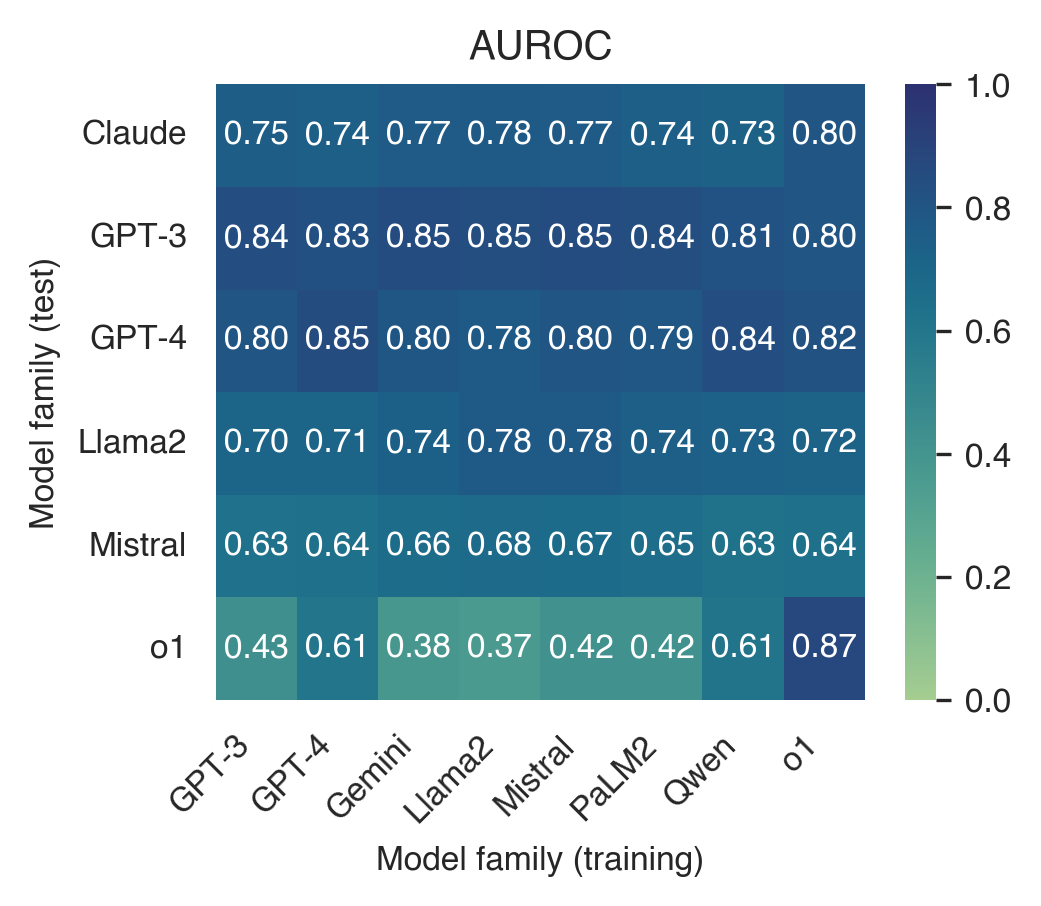

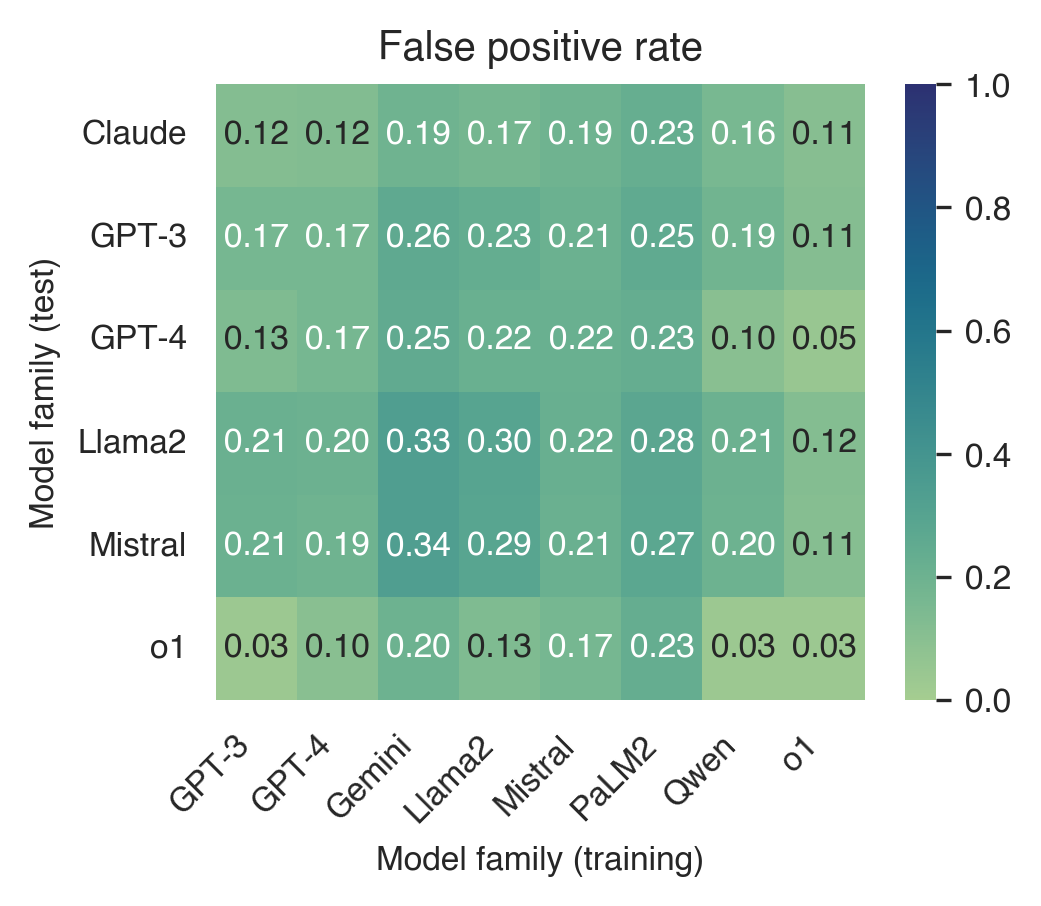

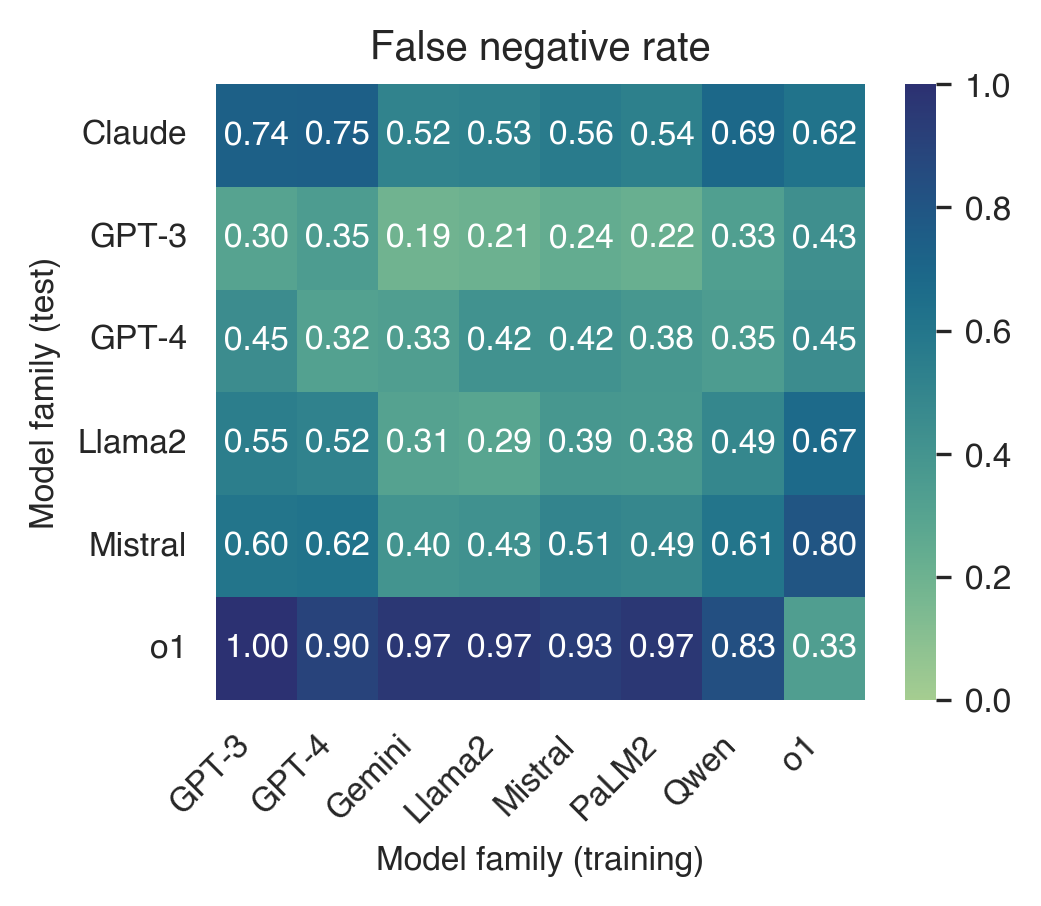

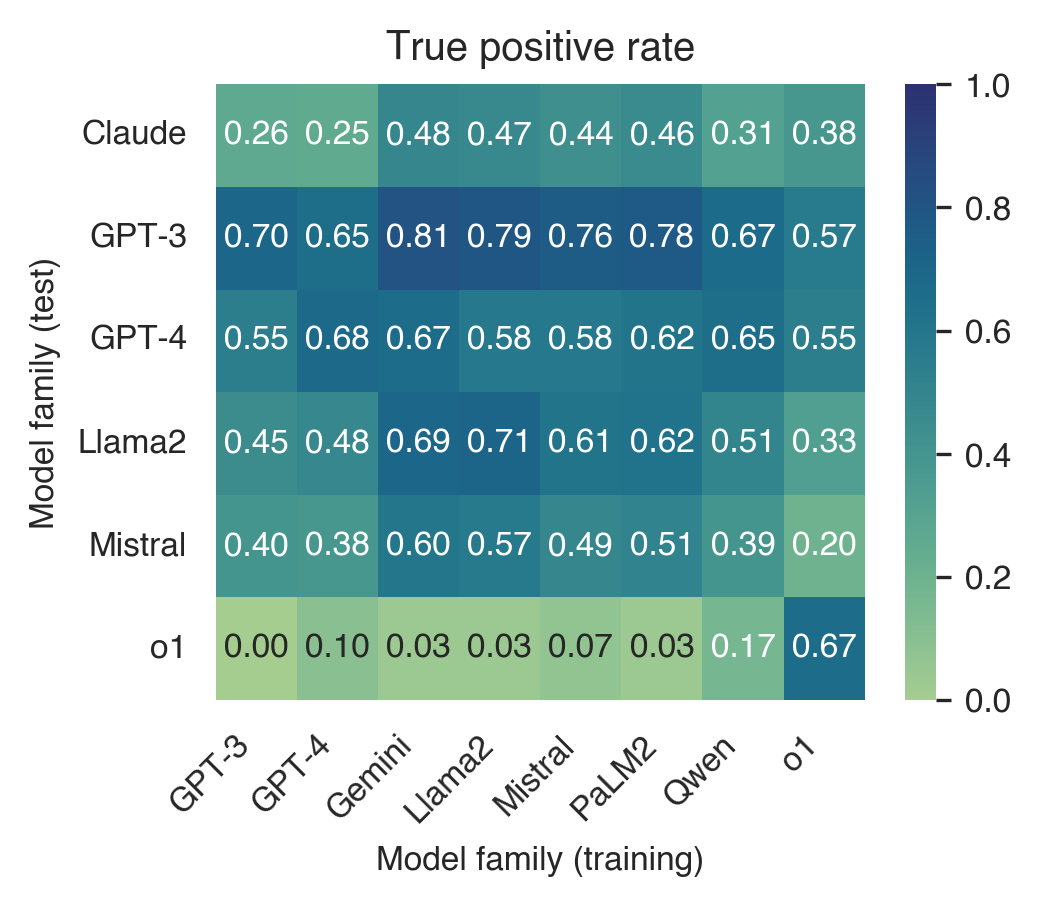

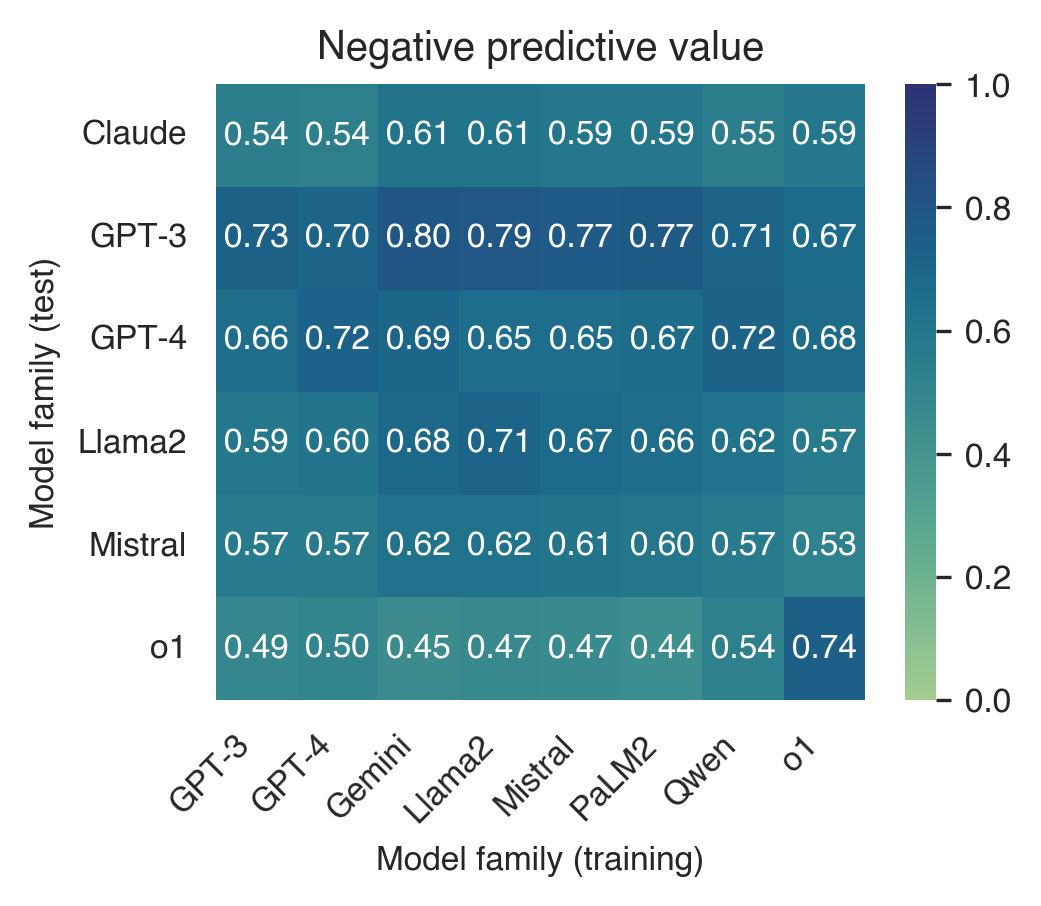

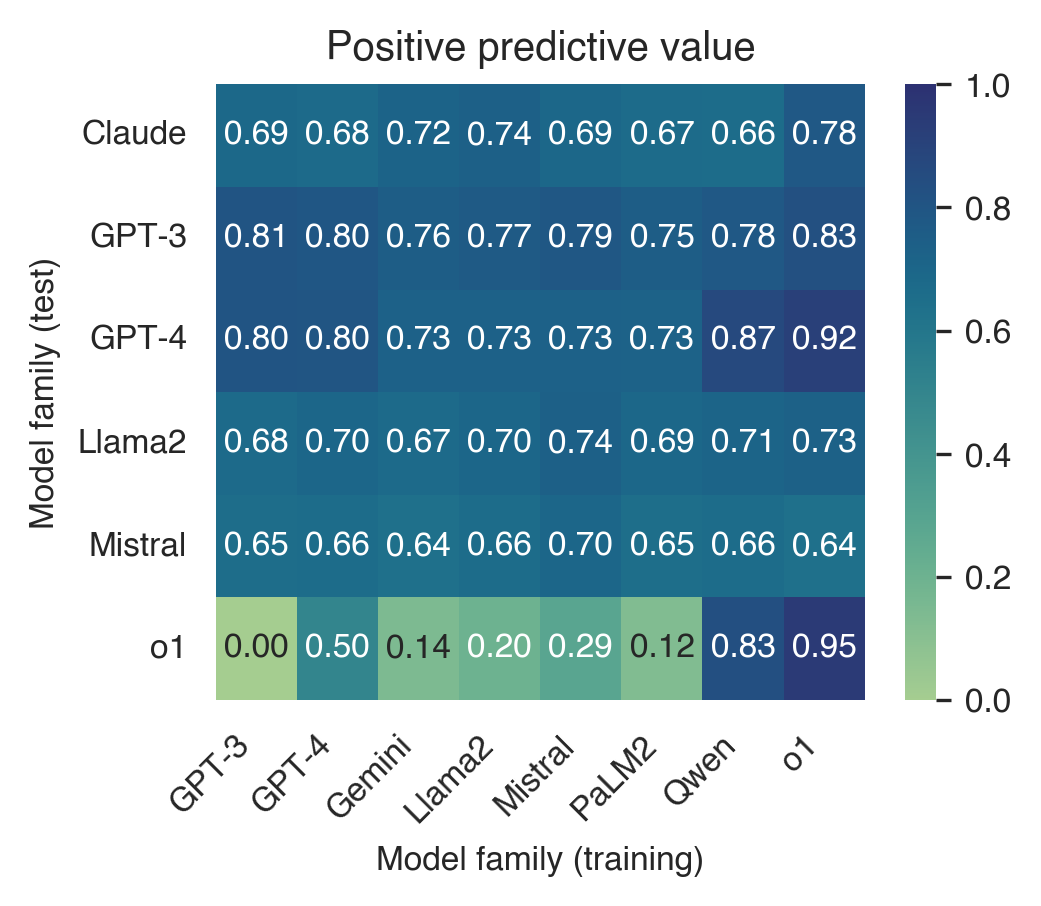

In [91]:
plot_classification_heatmap(metrics_mixed, 'auc_roc', title='AUROC', savefig='../data/figures/classification-svm-mixed-auroc.pdf')
plot_classification_heatmap(metrics_mixed, 'fpr', title='False positive rate', savefig='../data/figures/classification-svm-mixed-fpr.pdf')
plot_classification_heatmap(metrics_mixed, 'fnr', title='False negative rate', savefig='../data/figures/classification-svm-mixed-fnr.pdf')
plot_classification_heatmap(metrics_mixed, 'machine_rec', title='True positive rate', savefig='../data/figures/classification-svm-mixed-tpr.pdf')
plot_classification_heatmap(metrics_mixed, 'human_prec', title='Negative predictive value', savefig='../data/figures/classification-svm-mixed-npv.pdf')
plot_classification_heatmap(metrics_mixed, 'machine_prec', title='Positive predictive value', savefig='../data/figures/classification-svm-mixed-ppv.pdf')

### Effectiveness Curves

In [21]:
# Build (balanced) dataset
def get_balanced(ds, w_h=1.0, w_m=1.0):
    h = ds.query('label == 0').sample(frac=1, random_state=42)
    m = ds.query('label == 1').sample(frac=1, random_state=42)
    n = min(len(h), len(m))
    return pd.concat([h.iloc[:int(n * w_h)], m.iloc[:int(n * w_m)]])

In [22]:
# Train model
vec = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
clf = LinearSVC()
train = get_balanced(ds_pan)
clf.fit(vec.fit_transform(train['text']), train['label']);

In [23]:
def plot_effectiveness_curves(balance, true_labels, scores, savefig=None):
    fig, (ax_roc, ax_prec_rec) = plt.subplots(1, 2, figsize=(4, 1.95))

    df_roc = []
    df_prec_rec = []
    for b, t, s in zip(balance, true_labels, scores):
        fpr, tpr, _ = roc_curve(t, s, drop_intermediate=False)
        au = f'{auc(fpr, tpr):.2f}'.lstrip('0')
        l = f'P/N = {b:.1f}, A = {au}'
        df_roc.append(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'legend': [l] * len(fpr)}))

        prec, rec, _ = precision_recall_curve(t, s)
        au = f'{auc(rec, prec):.2f}'.lstrip('0')
        l = f'P/N = {b:.1f}, A = {au}'
        df_prec_rec.append(pd.DataFrame({'prec': prec, 'rec': rec, 'legend': [l] * len(prec)}))

    ticks = [0, .2, .4, .6, .8, 1]
    tick_labels = [f'{t:.1f}'.replace('.0', '') for t in ticks]

    df_roc = pd.concat(df_roc)
    sns.lineplot(ax=ax_roc, data=df_roc, x='fpr', y='tpr', hue='legend', style='legend', errorbar=None, clip_on=False)
    ax_roc.set_xlabel('False positive rate')
    ax_roc.set_ylabel('True positive rate')
    ax_roc.set_xlim((-.005, 1.005))
    ax_roc.set_ylim((-.005, 1.005))
    ax_roc.set_xticks(ticks)
    ax_roc.set_xticklabels(tick_labels)
    ax_roc.set_yticks(ticks)
    ax_roc.set_yticklabels(tick_labels)
    ax_roc.set_title('ROC')
    ax_roc.legend(title=None, frameon=False, borderpad=0)
    sns.despine(ax=ax_roc, trim=True, left=True, bottom=True)
    sns.move_legend(ax_roc, 'lower right', bbox_to_anchor=(1.03, -.05))

    df_prec_rec = pd.concat(df_prec_rec)
    sns.lineplot(ax=ax_prec_rec, data=df_prec_rec, x='rec', y='prec', hue='legend', style='legend', errorbar=None, clip_on=False)
    ax_prec_rec.set_xlabel('Recall')
    ax_prec_rec.set_ylabel('Precision')
    ax_prec_rec.set_xlim((-.005, 1.005))
    ax_prec_rec.set_ylim((-.005, 1.005))
    ax_prec_rec.set_xticks(ticks)
    ax_prec_rec.set_xticklabels(tick_labels)
    ax_prec_rec.set_yticks(ticks)
    ax_prec_rec.set_yticklabels(tick_labels)
    ax_prec_rec.set_title('Precision-Recall')
    ax_prec_rec.legend(title=None, frameon=False, borderpad=0)
    sns.move_legend(ax_prec_rec, 'lower left', bbox_to_anchor=(-.02, -.05))
    sns.despine(ax=ax_prec_rec, trim=True, left=True, bottom=True)

    plt.tight_layout(pad=0.8)
    plt.subplots_adjust(wspace=.33, hspace=.05)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight', pad_inches=0.01)
    plt.show()

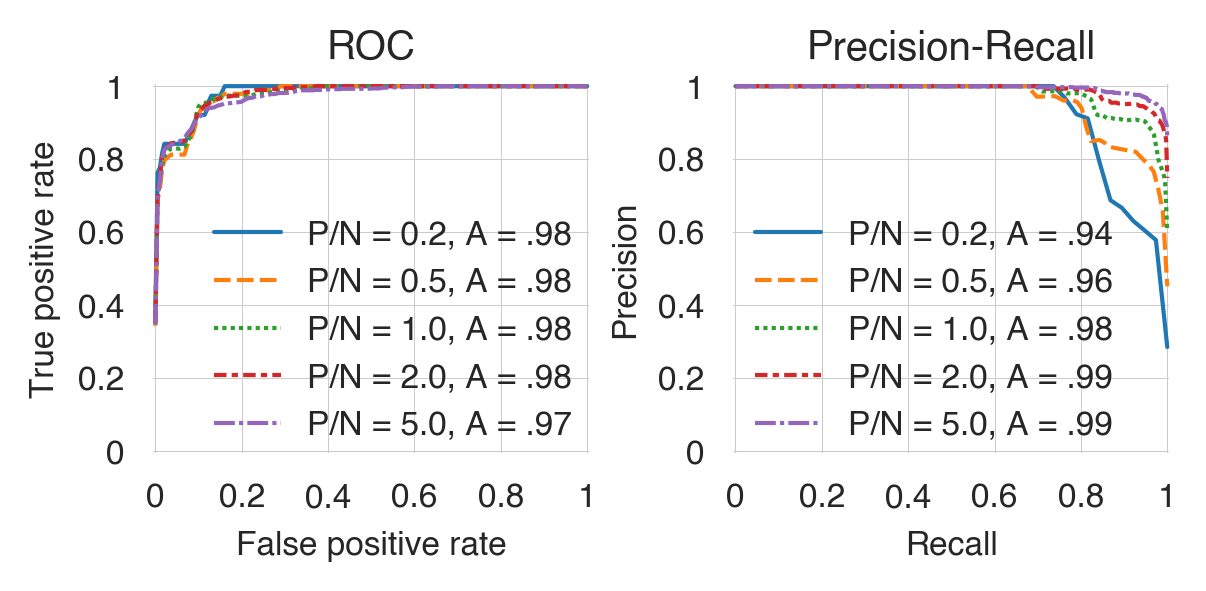

Accuracy  AUROC  TPR  FPR  PPV  NPV  FP  FN    P    N
Balance                                                       
0.20         0.90   0.98 0.92 0.11 0.62 0.98  21   3   38  193
0.50         0.91   0.98 0.94 0.11 0.81 0.97  21   6   96  193
1.00         0.92   0.98 0.95 0.11 0.90 0.95  21   9  193  193
2.00         0.93   0.98 0.94 0.11 0.95 0.89  21  22  386  193
5.00         0.92   0.97 0.92 0.11 0.98 0.70  21  74  965  193

In [24]:
metrics = []
scores = []
true_labels = []
for w in [0.2, 0.5, 1.0, 2.0, 5.0]:
    t = get_balanced(ds_mixed_small, w_m=w)
    p = clf._predict_proba_lr(vec.transform(t['text']))
    b_bin = p.argmax(axis=1)
    (tn, fp), (fn, tp) = confusion_matrix(t['label'], b_bin)
    scores.append(p[:, 1])
    true_labels.append(t['label'])
    metrics.append({
        'Balance': (tp + fn) / (tn + fp),
        'Accuracy': (b_bin == t['label']).mean(),
        'AUROC': roc_auc_score(t['label'], p[:, 1]),
        'TPR': tp / (tp + fn),
        'FPR': fp / (fp + tn),
        'PPV': tp / (tp + fp),
        'NPV': tn / (tn + fn),
        'FP': fp,
        'FN': fn,
        'P': tp + fn,
        'N': tn + fp,
    })

metrics = pd.DataFrame(metrics).set_index('Balance')
plot_effectiveness_curves(metrics.index, true_labels, scores, savefig='../data/figures/auc-vs-prec-rec.pdf')
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(metrics)

### Mistral Finetuning

In [25]:
ds_name_map = {
    'ghostbuster-essay': 'GB Essays',
    'ghostbuster-reuters': 'GB Reuters',
    'human-detectors': 'HD',
    'm4': 'M4',
    'mage': 'MAGE',
    'pan24': 'PAN',
    'raid': 'RAID',
}

In [26]:
preds_mistral = defaultdict(dict)
metrics_mistral = []
for p in Path('../data/eval-out').glob('mistral-*.csv'):
    tr_, te_ = p.stem.replace('mistral-', '').split('-', 1)
    tr = ds_name_map.get(tr_, tr_)
    te = ds_name_map.get(te_, te_)

    df = pd.read_csv(p, index_col='id')
    df = df.join(load_from_disk(f'../data/datasets/{te_}-converted')['test'].to_pandas().set_index('id'), rsuffix='_r')
    preds_mistral[tr][te] = df
    if te == 'RAID':
        preds_mistral[tr][te + ' (no attacks)'] = df.query('attack == "none"')

for tr in preds_mistral:
    for te in preds_mistral[tr]:
        d = preds_mistral[tr][te]
        m_val = {'train': tr, 'test': te}
        m_val.update(compute_metrics(d['pred_label'], d['true_label']), scores=d['score'].values)
        metrics_mistral.append(m_val)

metrics_mistral = pd.DataFrame(metrics_mistral).set_index(['train', 'test'])
metrics_mistral

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

acc   auc_roc                        confusion  \
train test                                                                     
RAID  M4                 0.526000  0.530712          [[120, 388], [86, 406]]   
      MAGE               0.701842  0.701508  [[18347, 11918], [6193, 24285]]   
      RAID               0.938933  0.907713       [[772, 113], [803, 13312]]   
      RAID (no attacks)  1.000000  1.000000               [[7, 0], [0, 127]]   
      GB Reuters         0.991667  0.970930              [[81, 5], [0, 514]]   
      HD                 0.444444  0.440711               [[6, 16], [9, 14]]   
      PAN                0.942740  0.499134            [[0, 272], [8, 4610]]   
      GB Essays          0.938333  0.782353             [[48, 37], [0, 515]]   
PAN   GB Reuters         0.980000  0.988327             [[86, 0], [12, 502]]   
      HD                 0.888889  0.891304               [[22, 0], [5, 18]]   
      M4                 0.845000  0.846833          [[372, 136], [19, 473]]   
      MAGE               0.577054  0.576101   [[9213, 21052], [4639, 25839]]   
      RAID               0.825467  0.717683      [[527, 358], [2260, 11855]]   
      RAID (no attacks)  0.895522  0.877390              [[6, 1], [13, 114]]   
      PAN                0.996933  0.994916           [[270, 2], [13, 4605]]   
      GB Essays          0.888333  0.605882             [[18, 67], [0, 515]]   

                              fpr       fnr  human_prec  human_rec  human_f1  \
train test                                                                     
RAID  M4                 0.763780  0.174797    0.582524   0.236220  0.336134   
      MAGE               0.393788  0.203196    0.747637   0.606212  0.669537   
      RAID               0.127684  0.056890    0.490159   0.872316  0.627642   
      RAID (no attacks)  0.000000  0.000000    1.000000   1.000000  1.000000   
      GB Reuters         0.058140  0.000000    1.000000   0.941860  0.970060   
      HD                 0.727273  0.391304    0.400000   0.272727  0.324324   
      PAN                1.000000  0.001732    0.000000   0.000000  0.000000   
      GB Essays          0.435294  0.000000    1.000000   0.564706  0.721805   
PAN   GB Reuters         0.000000  0.023346    0.877551   1.000000  0.934783   
      HD                 0.000000  0.217391    0.814815   1.000000  0.897959   
      M4                 0.267717  0.038618    0.951407   0.732283  0.827586   
      MAGE               0.695589  0.152208    0.665103   0.304411  0.417662   
      RAID               0.404520  0.160113    0.189092   0.595480  0.287037   
      RAID (no attacks)  0.142857  0.102362    0.315789   0.857143  0.461538   
      PAN                0.007353  0.002815    0.954064   0.992647  0.972973   
      GB Essays          0.788235  0.000000    1.000000   0.211765  0.349515   

                         machine_prec  machine_rec  machine_f1  \
train test                                                       
RAID  M4                     0.511335     0.825203    0.631415   
      MAGE                   0.670801     0.796804    0.728393   
      RAID                   0.991583     0.943110    0.966739   
      RAID (no attacks)      1.000000     1.000000    1.000000   
      GB Reuters             0.990366     1.000000    0.995160   
      HD                     0.466667     0.608696    0.528302   
      PAN                    0.944285     0.998268    0.970526   
      GB Essays              0.932971     1.000000    0.965323   
PAN   GB Reuters             1.000000     0.976654    0.988189   
      HD                     1.000000     0.782609    0.878049   
      M4                     0.776683     0.961382    0.859219   
      MAGE                   0.551044     0.847792    0.667942   
      RAID                   0.970687     0.839887    0.900562   
      RAID (no attacks)      0.991304     0.897638    0.942149   
      PAN                    0.999566     0.997185    0.998374   
      GB Essays           

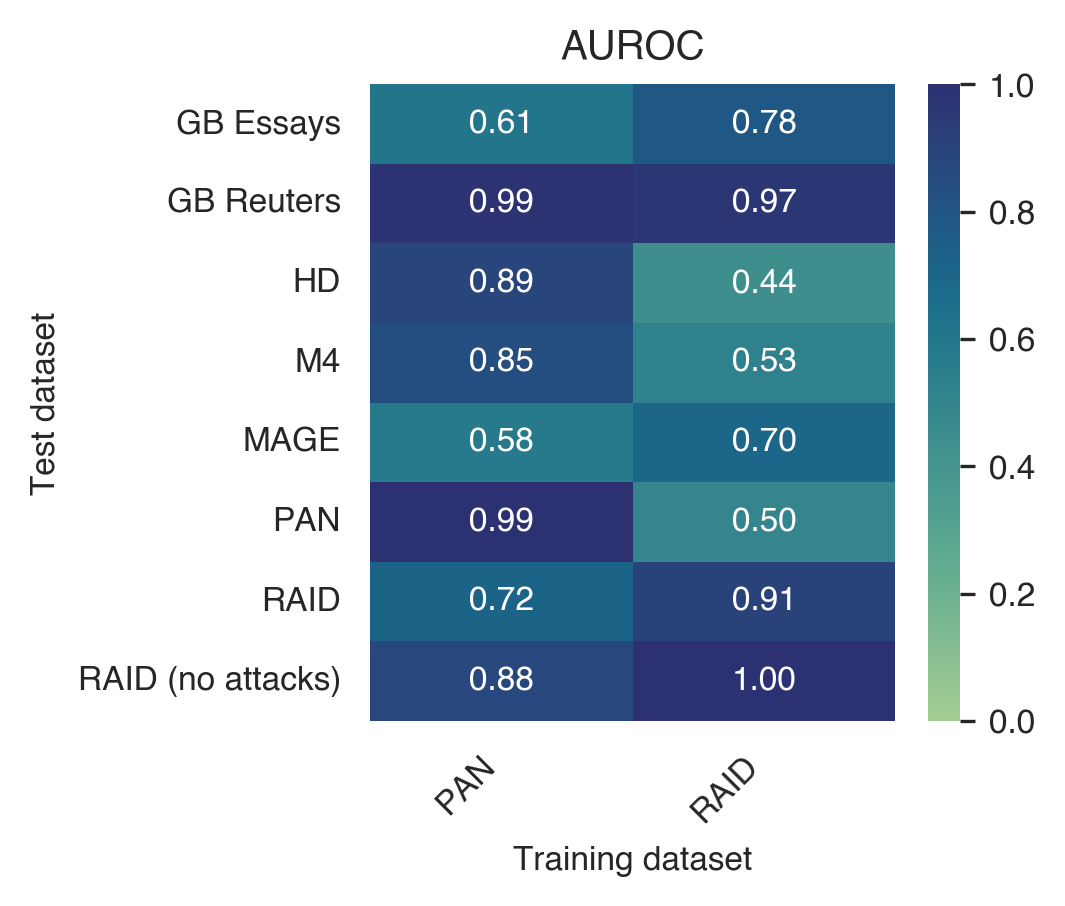

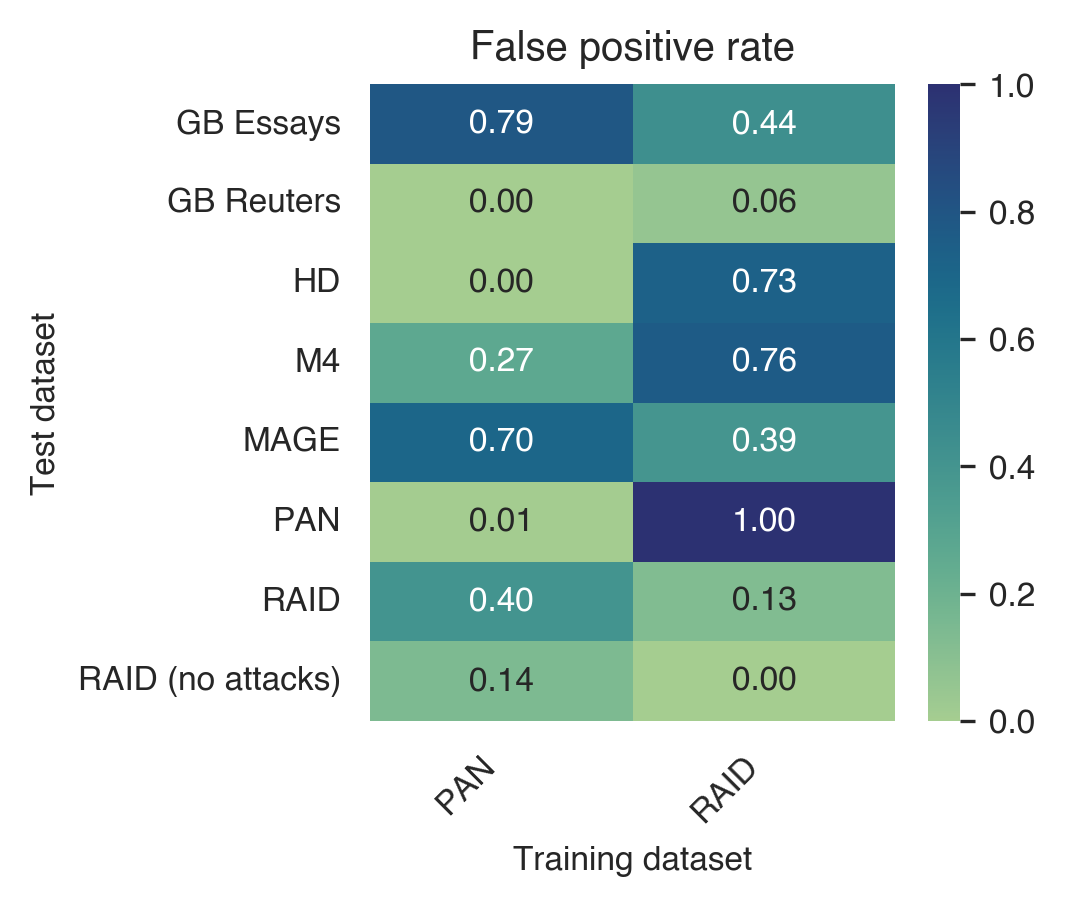

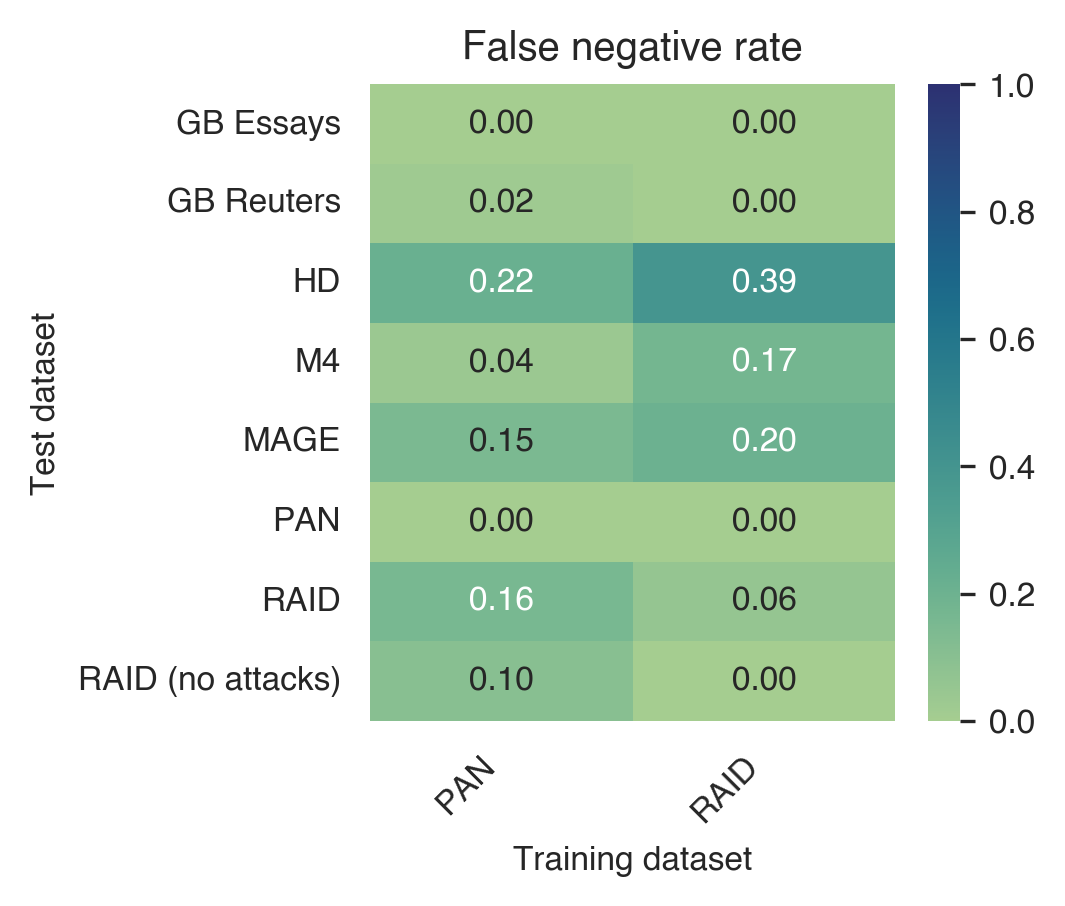

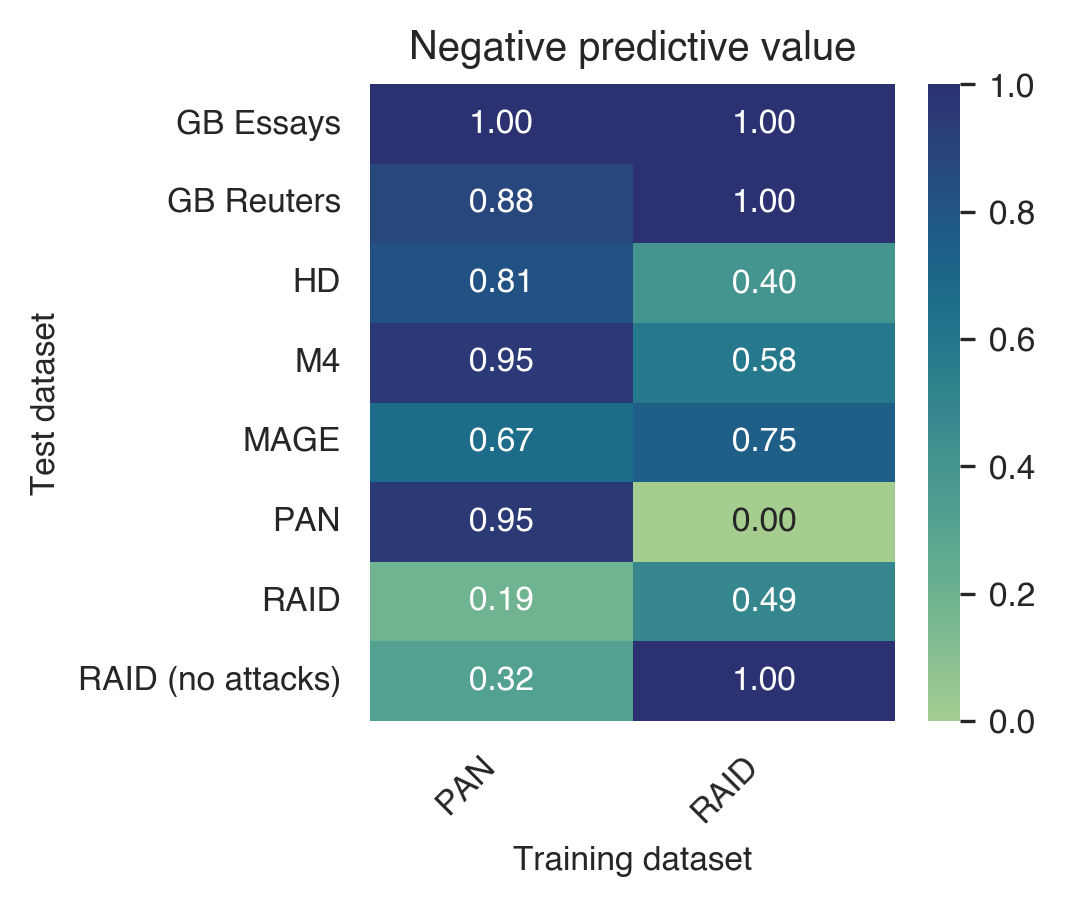

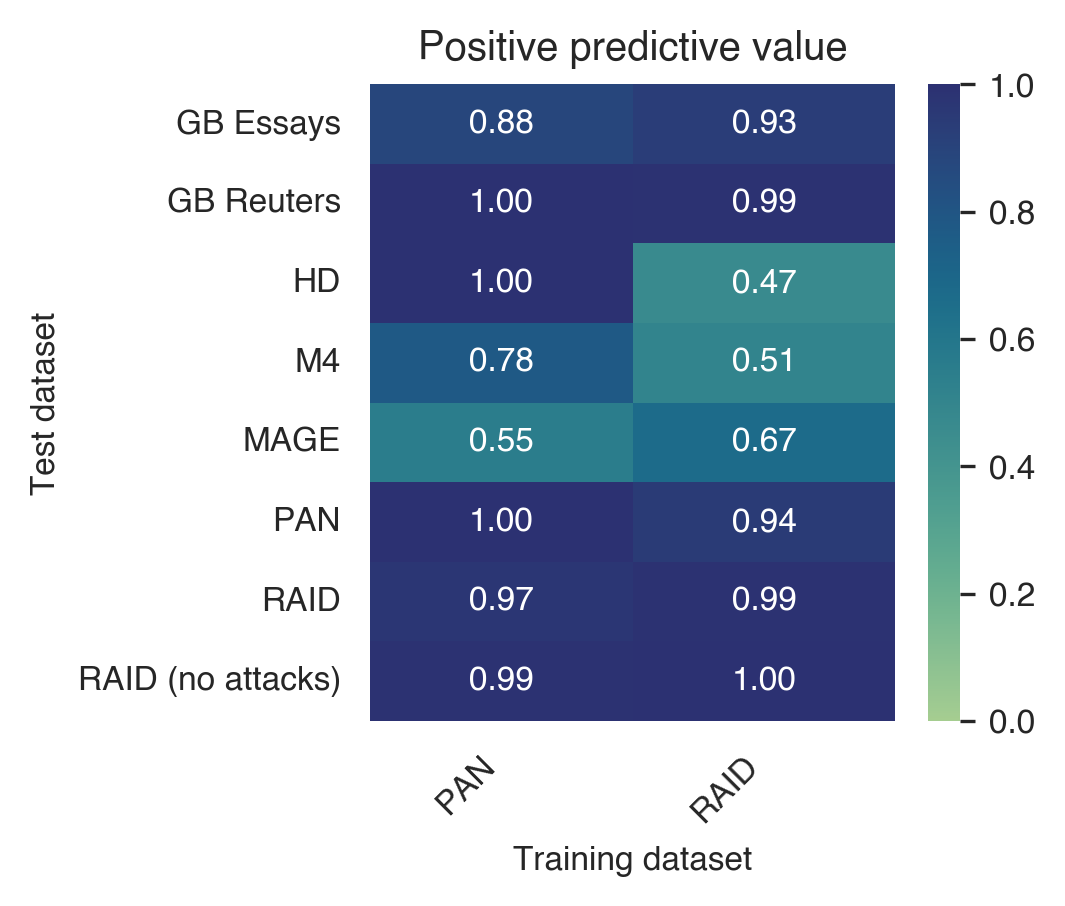

In [27]:
plot_classification_heatmap(metrics_mistral, 'auc_roc', title='AUROC', xlabel='Training dataset', ylabel='Test dataset', savefig='../data/figures/classification-mistral-mixed-auroc.pdf')
plot_classification_heatmap(metrics_mistral, 'fpr', title='False positive rate', xlabel='Training dataset', ylabel='Test dataset', savefig='../data/figures/classification-mistral-mixed-fpr.pdf')
plot_classification_heatmap(metrics_mistral, 'fnr', title='False negative rate', xlabel='Training dataset', ylabel='Test dataset', savefig='../data/figures/classification-mistral-mixed-fnr.pdf')
plot_classification_heatmap(metrics_mistral, 'human_prec', title='Negative predictive value', xlabel='Training dataset', ylabel='Test dataset', savefig='../data/figures/classification-mistral-mixed-npv.pdf')
plot_classification_heatmap(metrics_mistral, 'machine_prec', title='Positive predictive value', xlabel='Training dataset', ylabel='Test dataset', savefig='../data/figures/classification-mistral-mixed-ppv.pdf')

### Binoculars on All Datasets

In [28]:
thresh = {
    'Low FNR': -0.97,
    'Accuracy': -0.9015310749276843,
    'Low FPR': -0.8536432310785527
}

preds_binoculars = {}
metrics_binoculars = []

for p in Path('../data/eval-out').glob('binoculars-*.csv'):
    te_ = p.stem.replace('binoculars-', '')
    df = pd.read_csv(p, index_col='id')
    te = ds_name_map.get(te_, te_)

    preds_binoculars[te] = df
    df = df.join(load_from_disk(f'../data/datasets/{te_}-converted')['test'].to_pandas().set_index('id'), rsuffix='_r')
    preds_binoculars[te] = df
    if te == 'RAID':
        preds_binoculars[te + ' (no attack)'] = df.query('attack == "none"')

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

In [29]:
for n, t in thresh.items():
    for te in preds_binoculars:
        m_val = {'train': n, 'test': te}
        d = preds_binoculars[te]
        m_val.update(compute_metrics(d['score'] > t, d['true_label']), scores=d['score'].values)
        metrics_binoculars.append(m_val)

metrics_binoculars = pd.DataFrame(metrics_binoculars).set_index(['train', 'test'])
metrics_binoculars

acc   auc_roc  \
train    test                                   
Low FNR  M4                0.731000  0.733604   
         MAGE              0.576001  0.575870   
         RAID              0.884867  0.750305   
         RAID (no attack)  0.873134  0.865579   
         GB Reuters        0.963333  0.886617   
         HD                0.777778  0.775692   
         PAN               0.938446  0.780574   
         GB Essays         0.956667  0.847059   
Accuracy M4                0.826000  0.823715   
         MAGE              0.650544  0.651188   
         RAID              0.771333  0.818659   
         RAID (no attack)  0.813433  0.901575   
         GB Reuters        0.940000  0.964981   
         HD                0.888889  0.891304   
         PAN               0.764213  0.864783   
         GB Essays         0.975000  0.980525   
Low FPR  M4                0.764000  0.760195   
         MAGE              0.653853  0.654759   
         RAID              0.648267  0.796161   
         RAID (no attack)  0.768657  0.877953   
         GB Reuters        0.833333  0.902724   
         HD                0.688889  0.695652   
         PAN               0.599387  0.787895   
         GB Essays         0.906667  0.945631   

                                                  confusion       fpr  \
train    test                                                           
Low FNR  M4                         [[290, 218], [51, 441]]  0.429134   
         MAGE              [[16299, 13966], [11789, 18689]]  0.461457   
         RAID                   [[529, 356], [1371, 12744]]  0.402260   
         RAID (no attack)               [[6, 1], [16, 111]]  0.142857   
         GB Reuters                    [[67, 19], [3, 511]]  0.220930   
         HD                              [[15, 7], [3, 20]]  0.318182   
         PAN                      [[164, 108], [193, 4425]]  0.397059   
         GB Essays                     [[59, 26], [0, 515]]  0.305882   
Accuracy M4                         [[491, 17], [157, 335]]  0.033465   
         MAGE               [[25270, 4995], [16232, 14246]]  0.165042   
         RAID                   [[772, 113], [3317, 10798]]  0.127684   
         RAID (no attack)               [[7, 0], [25, 102]]  0.000000   
         GB Reuters                    [[86, 0], [36, 478]]  0.000000   
         HD                              [[22, 0], [5, 18]]  0.000000   
         PAN                       [[266, 6], [1147, 3471]]  0.022059   
         GB Essays                     [[84, 1], [14, 501]]  0.011765   
Low FPR  M4                          [[507, 1], [235, 257]]  0.001969   
         MAGE               [[27639, 2626], [18400, 12078]]  0.086767   
         RAID                     [[853, 32], [5244, 8871]]  0.036158   
         RAID (no attack)                [[7, 0], [31, 96]]  0.000000   
         GB Reuters                   [[86, 0], [100, 414]]  0.000000   
         HD                              [[22, 0], [14, 9]]  0.000000   
         PAN                       [[272, 0], [1959, 2659]]  0.000000   
         GB Essays                     [[85, 0], [56, 459]]  0.000000   

                                fnr  human_prec  human_rec  human_f1  \
train    test                                                          
Low FNR  M4                0.103659    0.850440   0.570866  0.683157   
         MAGE              0.386804    0.580283   0.538543  0.558635   
         RAID              0.097131    0.278421   0.597740  0.379892   
         RAID (no attack)  0.125984    0.272727   0.857143  0.413793   
         GB Reuters        0.005837    0.957143   0.779070  0.858974   
         HD                0.130435    0.833333   0.681818  0.750000   
         PAN               0.041793    0.459384   0.602941  0.521463   
         GB Essays         0.000000    1.000000   0.694118  0.819444   
Accuracy M4                0.319106    0.757716   0.966535  0.849481   
         MAGE              0.532581    0.608886   0.834958  0.7042

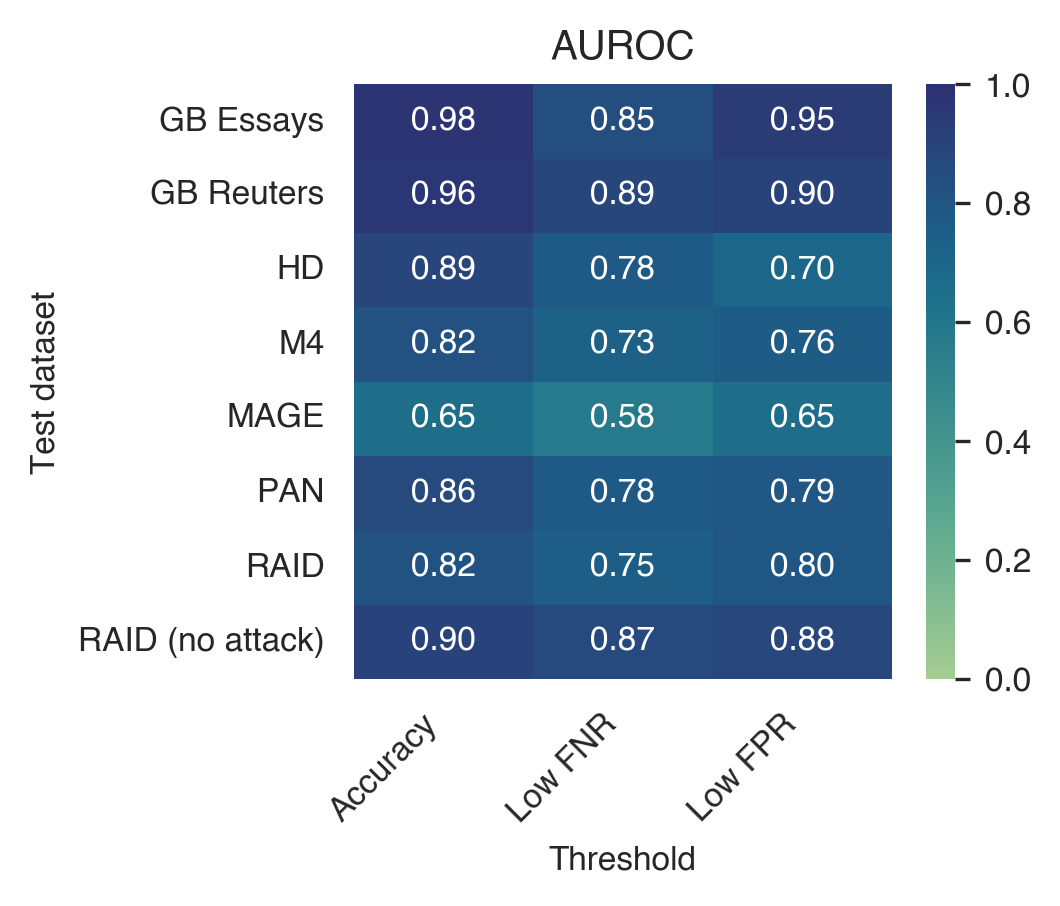

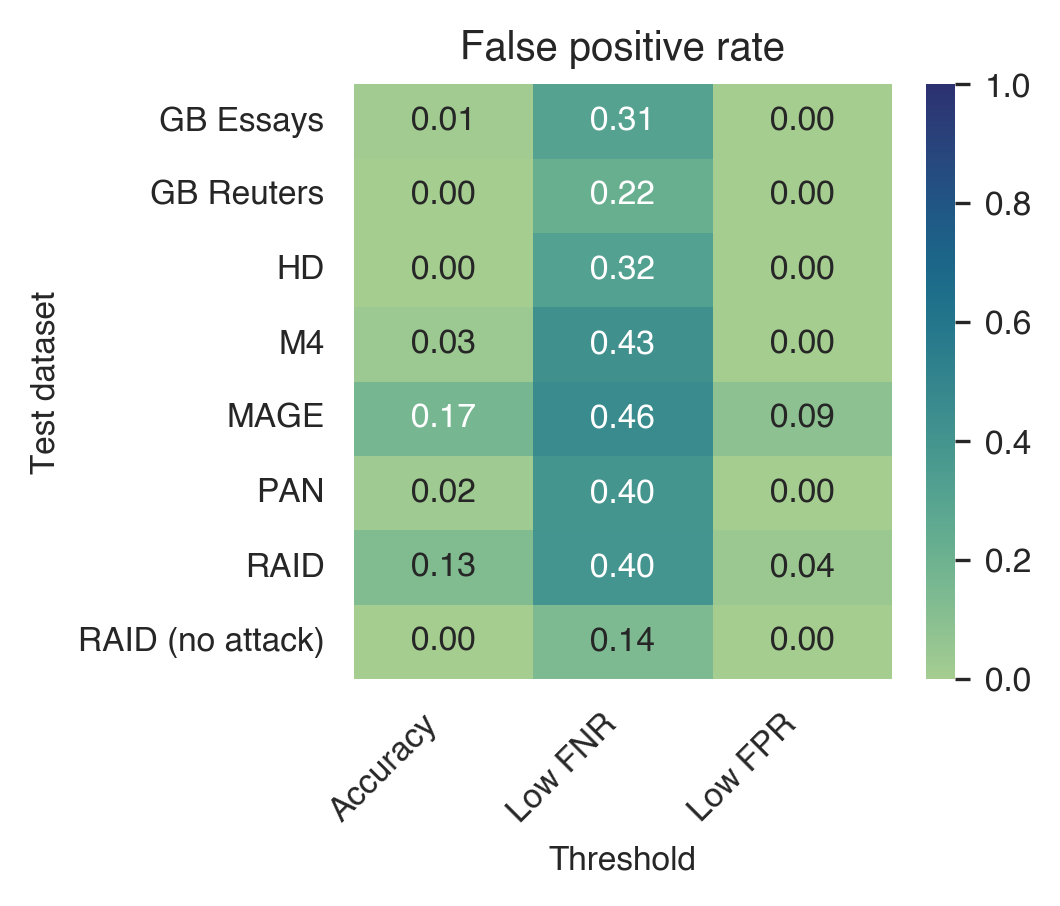

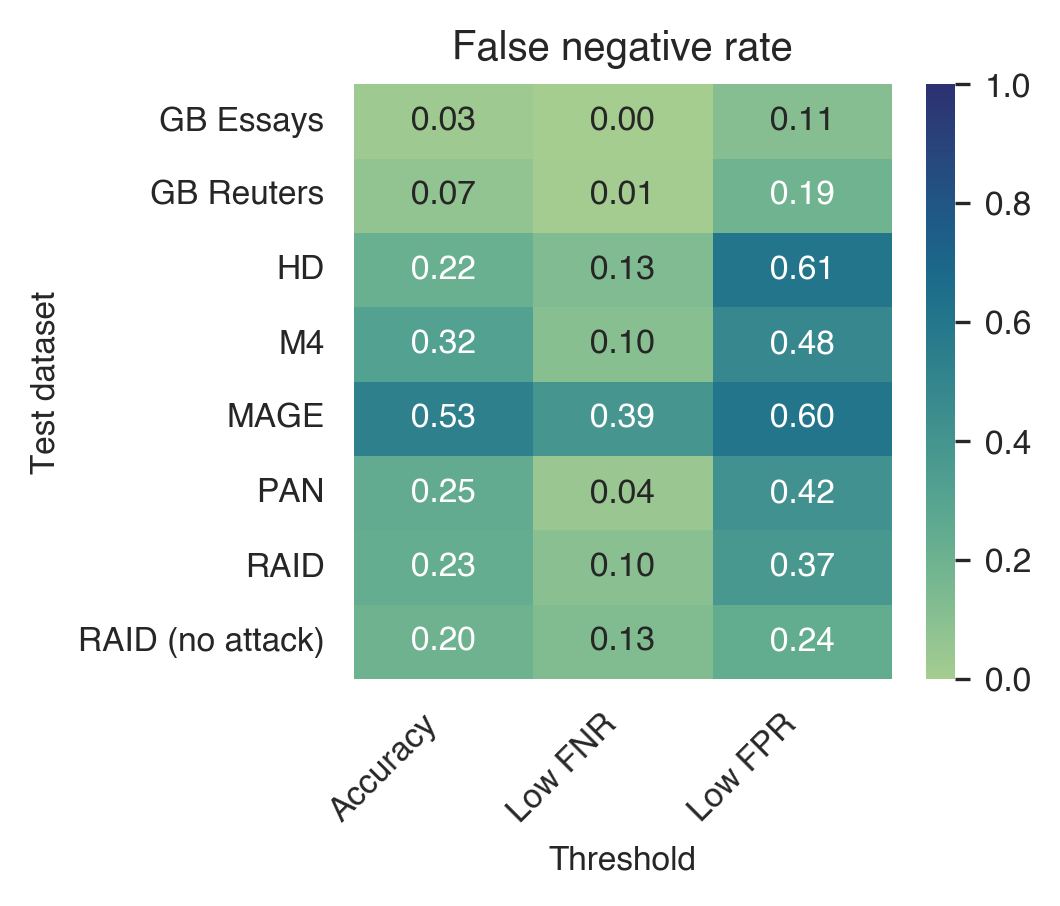

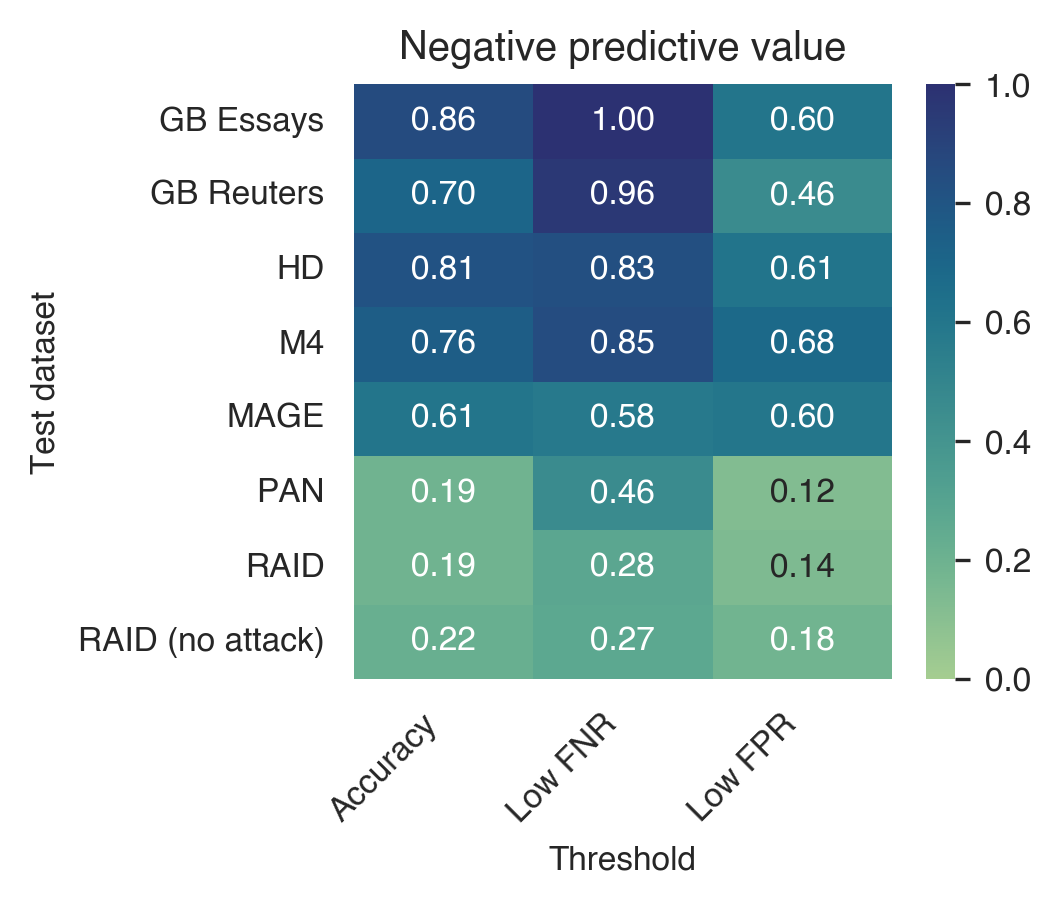

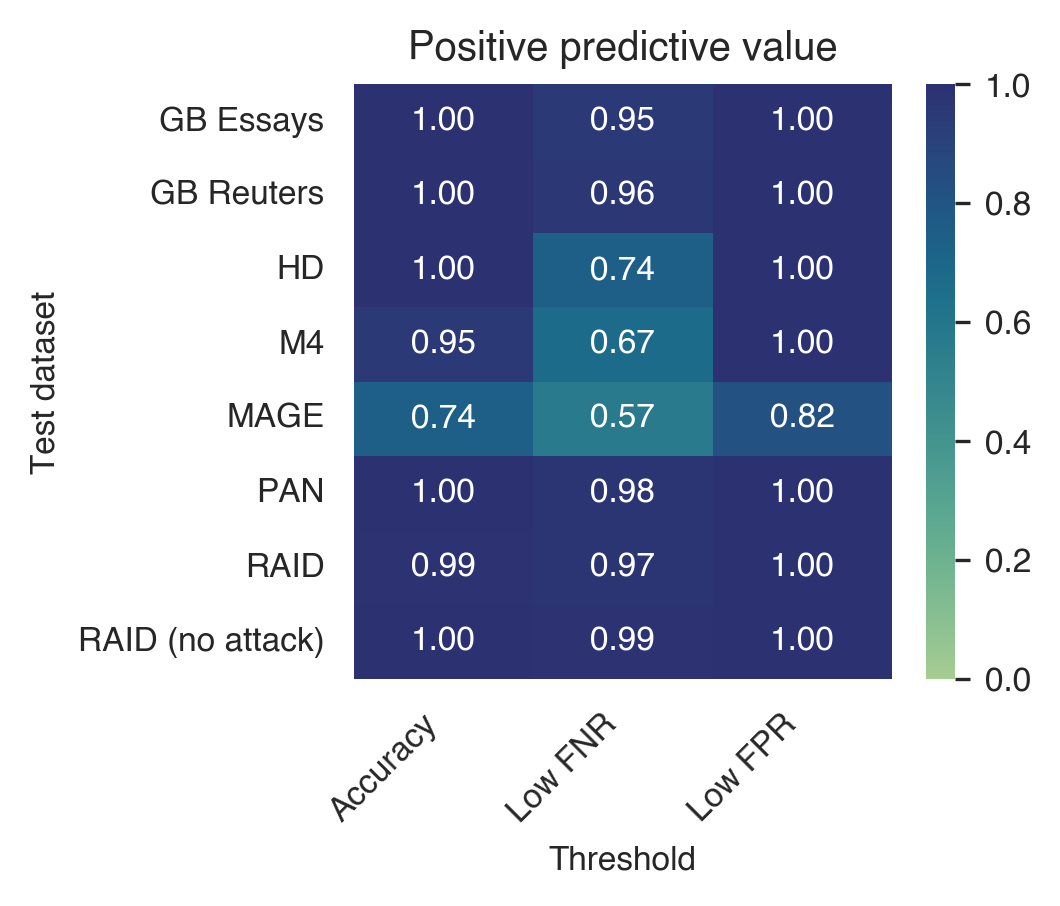

In [30]:
plot_classification_heatmap(metrics_binoculars, 'auc_roc', title='AUROC', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-mixed-auroc.pdf')
plot_classification_heatmap(metrics_binoculars, 'fpr', title='False positive rate', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-mixed-fpr.pdf')
plot_classification_heatmap(metrics_binoculars, 'fnr', title='False negative rate', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-mixed-fnr.pdf')
plot_classification_heatmap(metrics_binoculars, 'human_prec', title='Negative predictive value', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-mixed-npr.pdf')
plot_classification_heatmap(metrics_binoculars, 'machine_prec', title='Positive predictive value', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-mixed-npr.pdf')

### Binoculars on PAN

In [31]:
metrics_binoculars_pan = []
for (n, t), m in product(thresh.items(), df_pan_test_m):
    m_test = {'train': n, 'test': m}
    d = preds_binoculars['PAN'].join(test_pan[m], rsuffix='_r', how='inner')
    m_test.update(compute_metrics(d['score'] > t, d['true_label']), scores=d['score'].values)
    metrics_binoculars_pan.append(m_test)

metrics_binoculars_pan = pd.DataFrame(metrics_binoculars_pan).set_index(['train', 'test'])
metrics_binoculars_pan

acc   auc_roc                confusion       fpr  \
train    test                                                             
Low FNR  GPT-3    0.794118  0.794118   [[164, 108], [4, 268]]  0.397059   
         GPT-4    0.727941  0.727941  [[164, 108], [40, 232]]  0.397059   
         o1       0.724265  0.724265  [[164, 108], [42, 230]]  0.397059   
         Llama2   0.801471  0.801471   [[164, 108], [0, 272]]  0.397059   
         PaLM2    0.798507  0.798507   [[161, 107], [1, 267]]  0.399254   
         Gemini   0.795956  0.795956   [[164, 108], [3, 269]]  0.397059   
         Mistral  0.799632  0.799632   [[164, 108], [1, 271]]  0.397059   
         Qwen     0.801471  0.801471   [[164, 108], [0, 272]]  0.397059   
Accuracy GPT-3    0.871324  0.871324    [[266, 6], [64, 208]]  0.022059   
         GPT-4    0.661765  0.661765    [[266, 6], [178, 94]]  0.022059   
         o1       0.562500  0.562500    [[266, 6], [232, 40]]  0.022059   
         Llama2   0.987132  0.987132     [[266, 6], [1, 271]]  0.022059   
         PaLM2    0.986940  0.986940     [[262, 6], [1, 267]]  0.022388   
         Gemini   0.919118  0.919118    [[266, 6], [38, 234]]  0.022059   
         Mistral  0.937500  0.937500    [[266, 6], [28, 244]]  0.022059   
         Qwen     0.985294  0.985294     [[266, 6], [2, 270]]  0.022059   
Low FPR  GPT-3    0.700368  0.700368   [[272, 0], [163, 109]]  0.000000   
         GPT-4    0.545956  0.545956    [[272, 0], [247, 25]]  0.000000   
         o1       0.503676  0.503676     [[272, 0], [270, 2]]  0.000000   
         Llama2   0.981618  0.981618    [[272, 0], [10, 262]]  0.000000   
         PaLM2    0.968284  0.968284    [[268, 0], [17, 251]]  0.000000   
         Gemini   0.851103  0.851103    [[272, 0], [81, 191]]  0.000000   
         Mistral  0.854779  0.854779    [[272, 0], [79, 193]]  0.000000   
         Qwen     0.895221  0.895221    [[272, 0], [57, 215]]  0.000000   

                       fnr  human_prec  human_rec  human_f1  machine_prec  \
train    test                                                               
Low FNR  GPT-3    0.014706    0.976190   0.602941  0.745455      0.712766   
         GPT-4    0.147059    0.803922   0.602941  0.689076      0.682353   
         o1       0.154412    0.796117   0.602941  0.686192      0.680473   
         Llama2   0.000000    1.000000   0.602941  0.752294      0.715789   
         PaLM2    0.003731    0.993827   0.600746  0.748837      0.713904   
         Gemini   0.011029    0.982036   0.602941  0.747153      0.713528   
         Mistral  0.003676    0.993939   0.602941  0.750572      0.715040   
         Qwen     0.000000    1.000000   0.602941  0.752294      0.715789   
Accuracy GPT-3    0.235294    0.806061   0.977941  0.883721      0.971963   
         GPT-4    0.654412    0.599099   0.977941  0.743017      0.940000   
         o1       0.852941    0.534137   0.977941  0.690909      0.869565   
         Llama2   0.003676    0.996255   0.977941  0.987013      0.978339   
         PaLM2    0.003731    0.996198   0.977612  0.986817      0.978022   
         Gemini   0.139706    0.875000   0.977941  0.923611      0.975000   
         Mistral  0.102941    0.904762   0.977941  0.939929      0.976000   
         Qwen     0.007353    0.992537   0.977941  0.985185      0.978261   
Low FPR  GPT-3    0.599265    0.625287   1.000000  0.769448      1.000000   
         GPT-4    0.908088    0.524085   1.000000  0.687737      1.000000   
         o1       0.992647    0.501845   1.000000  0.668305      1.000000   
         Llama2   0.036765    0.964539   1.000000  0.981949      1.000000   
         PaLM2    0.063433    0.940351   1.000000  0.969259      1.000000   
         Gemini   0.297794    0.770538   1.000000  0.870400      1.000000   
         Mistral  0.290441    0.774929   1.000000  0.873194      1.000000   
         Qwen     0.209559    0.826748   1.000000  0.905158      1.000000   

                  machine_rec  machine_f1  \
train    test           

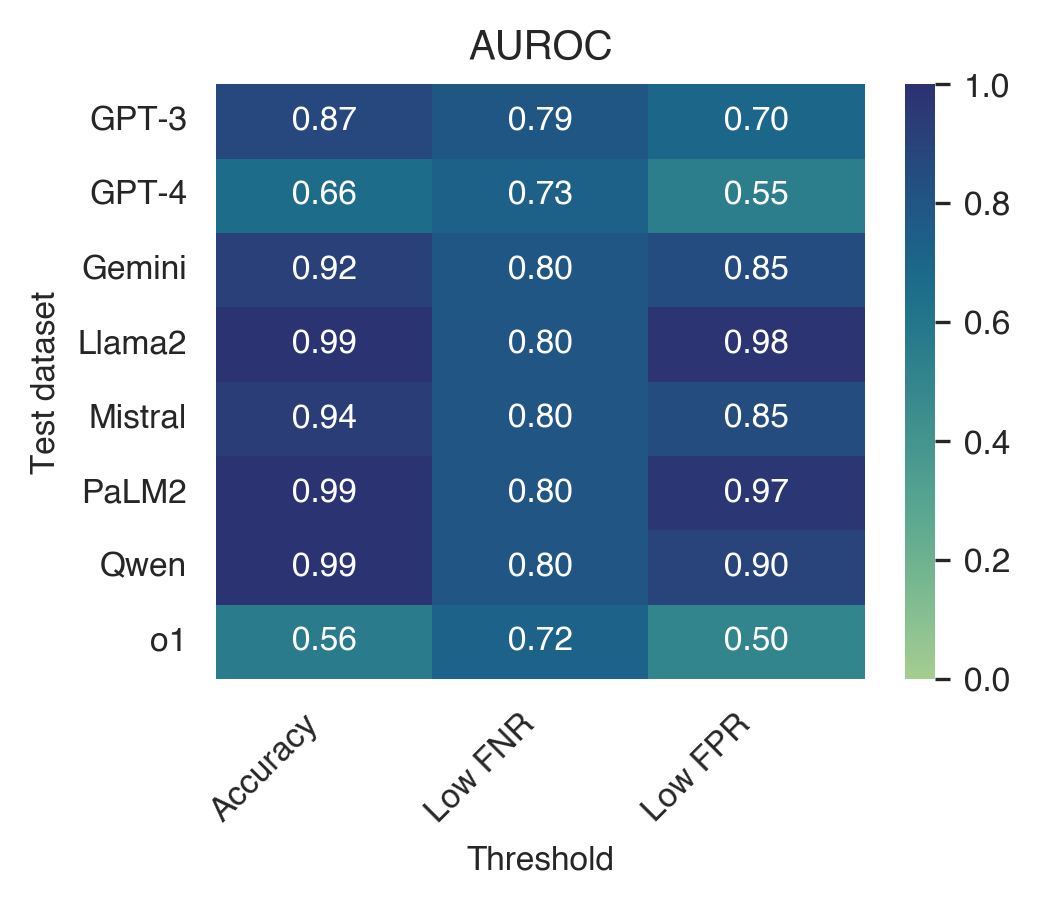

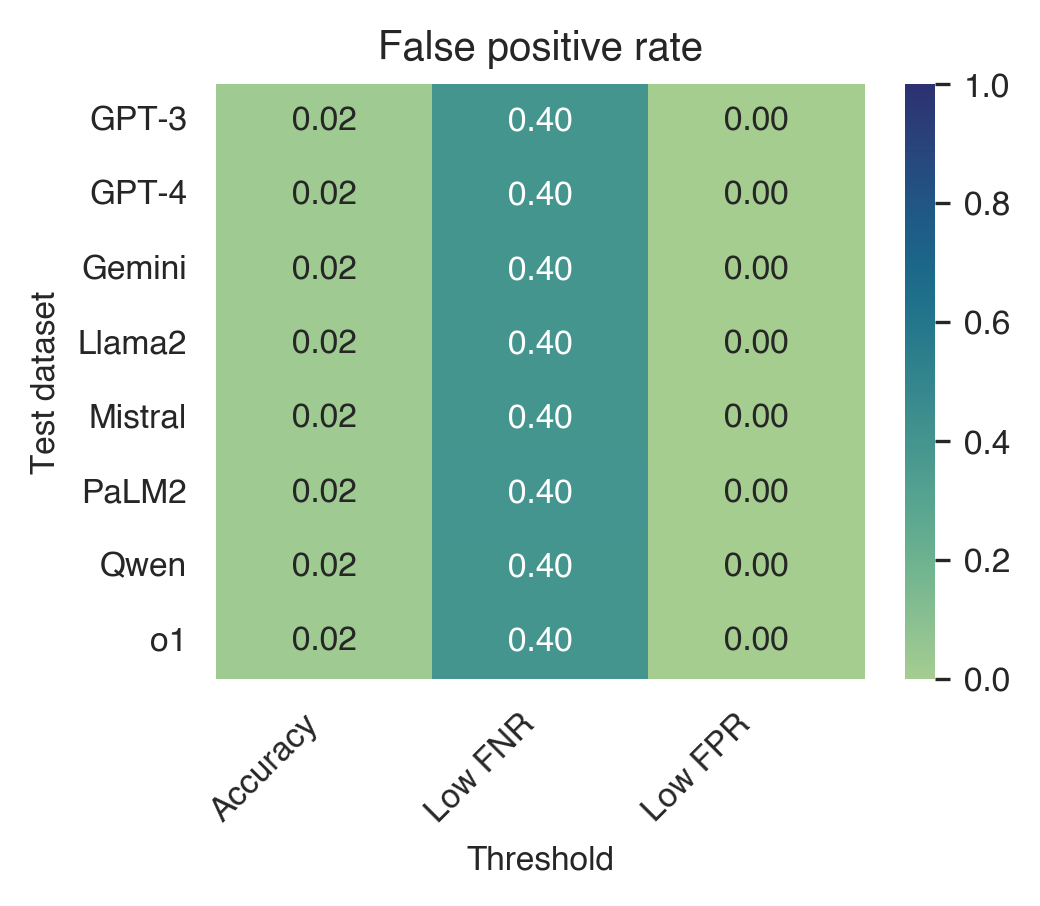

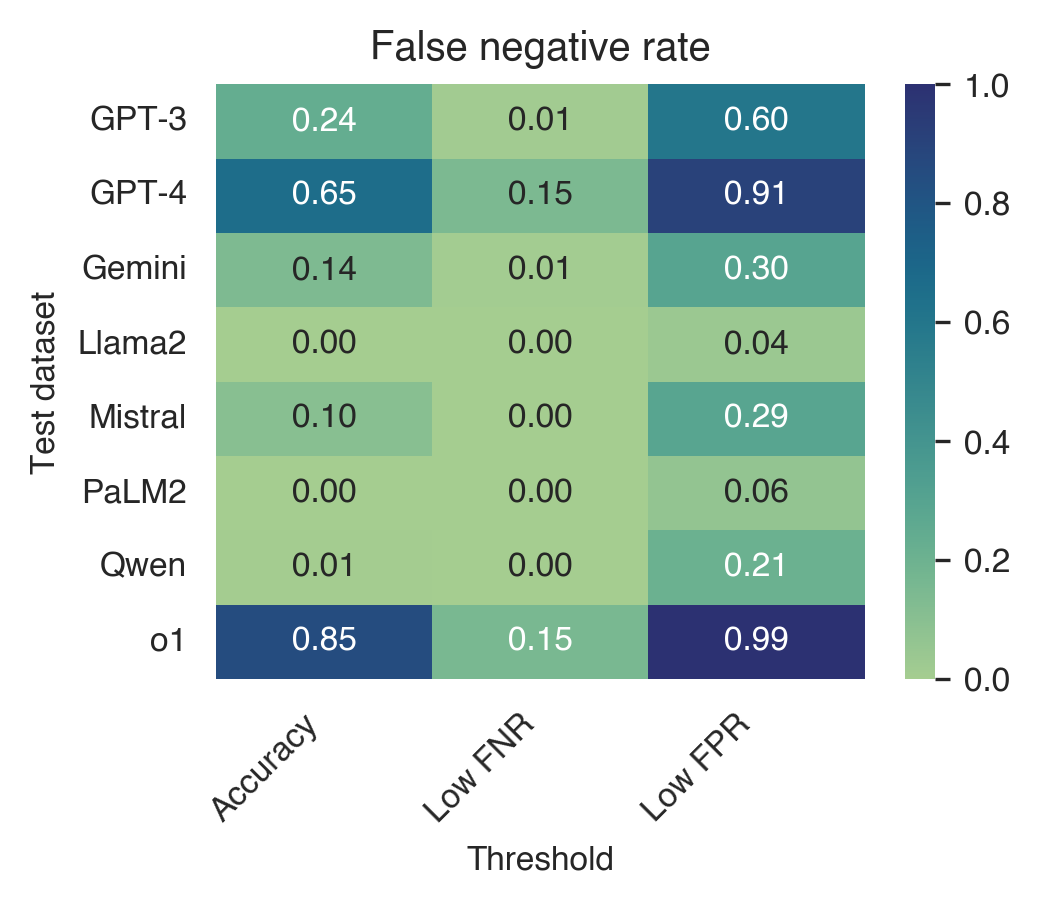

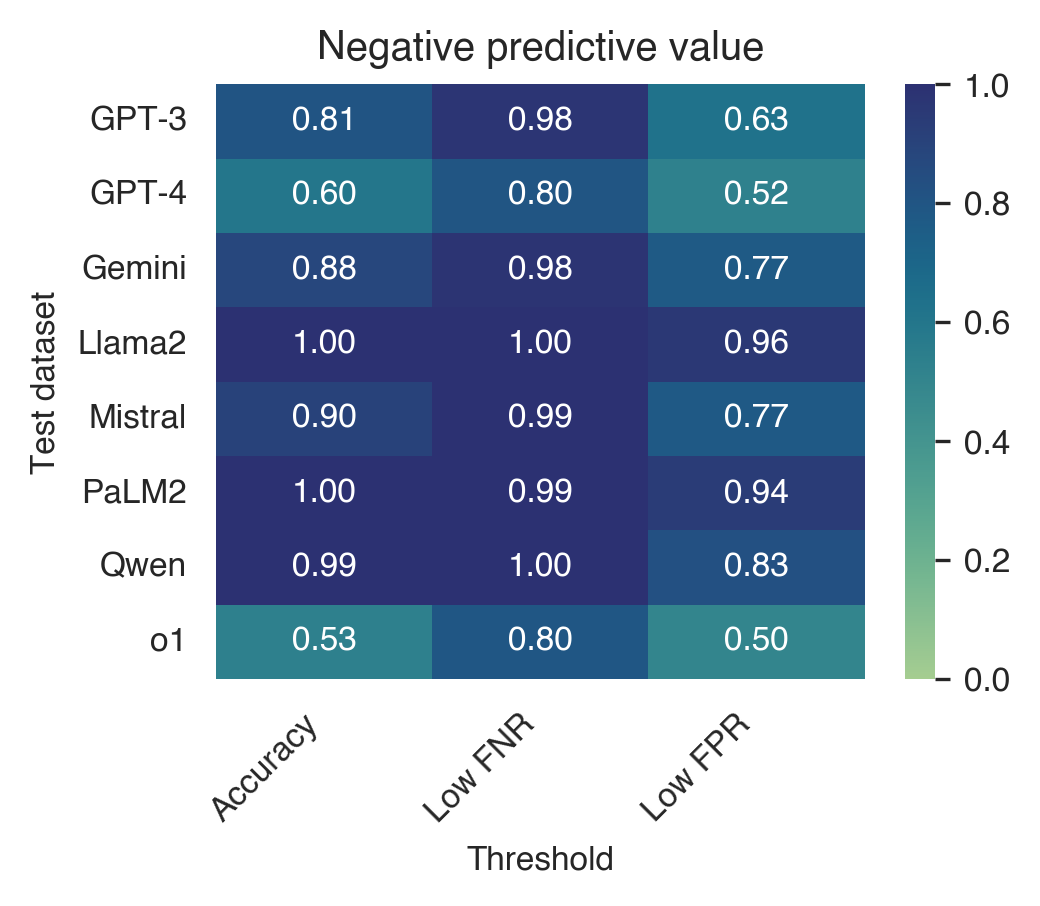

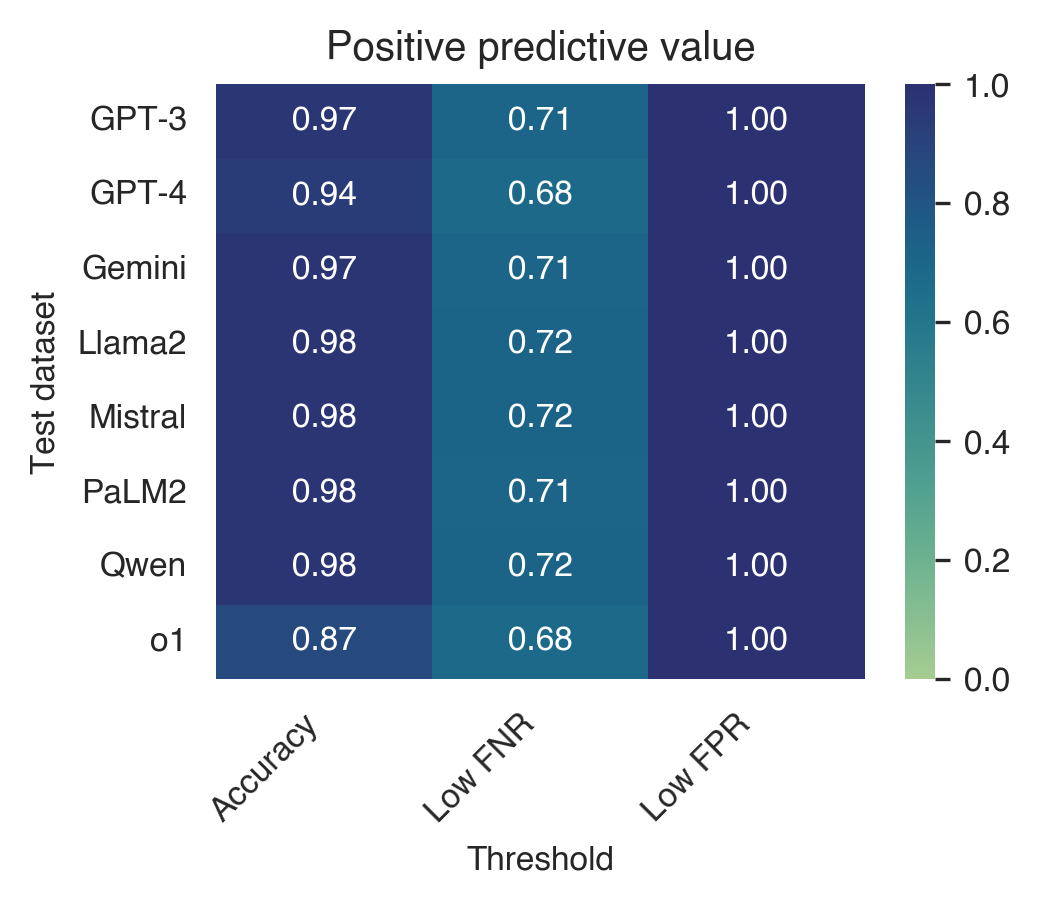

In [32]:
plot_classification_heatmap(metrics_binoculars_pan, 'auc_roc', title='AUROC', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-pan-auroc.pdf')
plot_classification_heatmap(metrics_binoculars_pan, 'fpr', title='False positive rate', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-pan-fpr.pdf')
plot_classification_heatmap(metrics_binoculars_pan, 'fnr', title='False negative rate', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-pan-fnr.pdf')
plot_classification_heatmap(metrics_binoculars_pan, 'human_prec', title='Negative predictive value', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-pan-npv.pdf')
plot_classification_heatmap(metrics_binoculars_pan, 'machine_prec', title='Positive predictive value', xlabel='Threshold', ylabel='Test dataset', savefig='../data/figures/classification-binoculars-pan-ppv.pdf')